<a href="https://colab.research.google.com/github/dmalya96/GAN/blob/main/Vanilla_GAN_Cifar10_IGMD_Layers_Truck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Vanilla GAN on Cifar 10 (Truck Images)

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.4.1'

In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from matplotlib import pyplot

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
  model = tf.keras.Sequential()
  # foundation for 4x4 image
  model.add(layers.Dense(4*4*512, use_bias=False, input_dim=latent_dim))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Reshape((4, 4, 512)))
  # upsample to 8x8
  model.add(layers.Conv2DTranspose(256, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  # upsample to 16x16
  model.add(layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  # upsample to 32x32
  model.add(layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  # output layer
  model.add(layers.Conv2D(3, (5,5), activation='tanh', padding='same'))
  return model

In [ ]:
# define the standalone discriminator model
def define_discriminator():
  model = tf.keras.Sequential()
  # normal
  model.add(layers.Conv2D(96, (3,3), padding='same', input_shape=[32, 32, 3]))
  model.add(layers.LeakyReLU(alpha=0.2))
  # downsample
  model.add(layers.Conv2D(96, (3,3), strides=1, padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2D(96, (3,3), strides=2, padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.5))
  # downsample
  model.add(layers.Conv2D(192, (3,3), strides=1, padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2D(192, (3,3), strides=1, padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2D(192, (3,3), strides=2, padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.5))
  # downsample
  model.add(layers.Conv2D(192, (3,3), strides=2, padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  # downsample
  model.add(layers.Conv2D(192, (3,3), strides=2, padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  # classifier
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = tf.keras.Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
# load and prepare cifar10 training images
def load_real_samples():
  # load cifar10 dataset
  (trainX, trainY), (_, _) = tf.keras.datasets.cifar10.load_data()
  # Select truck images (Class 9)
  trainX = trainX[trainY.flatten() == 9]
  # convert from unsigned ints to floats
  X = trainX.astype('float32')
  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  return X

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [ ]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=5):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png'
	pyplot.savefig(filename)
	pyplot.close()

In [ ]:
# evaluate the discriminator, plot generated images, save generator model

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# generate images
	latent_points = generate_latent_points(100, 100)
	X = g_model.predict(latent_points)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot the result
	create_plot(X, 5)

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=300, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 5 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

170500096/170498071 [==============================] - 6s 0us/step
>1, 1/39, d1=0.701, d2=0.695 g=0.692
>1, 2/39, d1=0.654, d2=0.696 g=0.691
>1, 3/39, d1=0.548, d2=0.714 g=0.675
>1, 4/39, d1=0.283, d2=0.901 g=0.593
>1, 5/39, d1=0.075, d2=1.224 g=0.593
>1, 6/39, d1=0.127, d2=0.923 g=0.658
>1, 7/39, d1=0.196, d2=0.733 g=0.714
>1, 8/39, d1=0.068, d2=0.652 g=0.837
>1, 9/39, d1=0.050, d2=0.541 g=1.330
>1, 10/39, d1=0.032, d2=0.364 g=2.436
>1, 11/39, d1=0.168, d2=0.420 g=1.458
>1, 12/39, d1=0.003, d2=0.549 g=1.062
>1, 13/39, d1=0.259, d2=0.823 g=0.863
>1, 14/39, d1=0.041, d2=0.932 g=0.739
>1, 15/39, d1=0.165, d2=0.864 g=0.732
>1, 16/39, d1=0.235, d2=0.679 g=0.824
>1, 17/39, d1=0.164, d2=0.569 g=1.056
>1, 18/39, d1=0.483, d2=0.643 g=0.744
>1, 19/39, d1=0.163, d2=0.628 g=0.799
>1, 20/39, d1=0.105, d2=0.606 g=0.868
>1, 21/39, d1=0.041, d2=0.534 g=1.046
>1, 22/39, d1=0.024, d2=0.417 g=1.373
>1, 23/39, d1=0.011, d2=0.364 g=1.497
>1, 24/39, d1=0.004, d2=0.292 g=1.854
>1, 25/39, d1=0.001, d2=0.257 

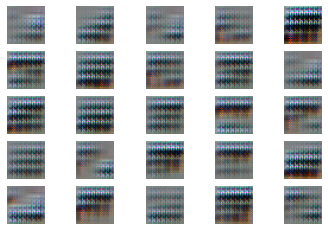

>6, 1/39, d1=0.155, d2=0.167 g=3.222
>6, 2/39, d1=0.309, d2=0.569 g=5.175
>6, 3/39, d1=1.029, d2=0.115 g=2.160
>6, 4/39, d1=0.088, d2=0.347 g=1.978
>6, 5/39, d1=0.142, d2=0.298 g=2.448
>6, 6/39, d1=0.583, d2=0.627 g=2.991
>6, 7/39, d1=0.591, d2=0.157 g=2.312
>6, 8/39, d1=0.413, d2=0.293 g=1.924
>6, 9/39, d1=0.267, d2=0.339 g=2.136
>6, 10/39, d1=0.297, d2=0.224 g=2.117
>6, 11/39, d1=0.202, d2=0.447 g=2.963
>6, 12/39, d1=0.591, d2=0.121 g=2.529
>6, 13/39, d1=0.487, d2=0.251 g=1.981
>6, 14/39, d1=0.304, d2=0.753 g=3.390
>6, 15/39, d1=1.425, d2=0.269 g=1.607
>6, 16/39, d1=0.699, d2=0.509 g=1.128
>6, 17/39, d1=0.413, d2=0.606 g=1.035
>6, 18/39, d1=0.419, d2=0.528 g=1.092
>6, 19/39, d1=0.356, d2=0.482 g=1.309
>6, 20/39, d1=0.373, d2=0.423 g=1.472
>6, 21/39, d1=0.439, d2=0.371 g=1.497
>6, 22/39, d1=0.340, d2=0.339 g=1.559
>6, 23/39, d1=0.279, d2=0.323 g=1.749
>6, 24/39, d1=0.186, d2=0.266 g=1.909
>6, 25/39, d1=0.150, d2=0.325 g=2.520
>6, 26/39, d1=0.274, d2=0.174 g=2.181
>6, 27/39, d1=0.355, 

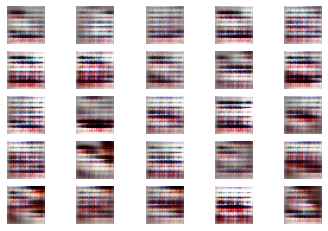

>11, 1/39, d1=0.292, d2=0.193 g=2.569
>11, 2/39, d1=0.198, d2=0.638 g=3.552
>11, 3/39, d1=0.383, d2=0.096 g=3.056
>11, 4/39, d1=0.330, d2=0.509 g=3.368
>11, 5/39, d1=0.444, d2=0.289 g=3.320
>11, 6/39, d1=0.673, d2=0.589 g=3.025
>11, 7/39, d1=0.577, d2=0.247 g=2.679
>11, 8/39, d1=0.539, d2=0.540 g=1.997
>11, 9/39, d1=0.358, d2=0.494 g=2.084
>11, 10/39, d1=0.593, d2=0.411 g=1.746
>11, 11/39, d1=0.514, d2=0.635 g=1.735
>11, 12/39, d1=0.676, d2=0.415 g=1.661
>11, 13/39, d1=0.660, d2=0.582 g=1.526
>11, 14/39, d1=0.516, d2=0.473 g=1.647
>11, 15/39, d1=0.406, d2=0.348 g=1.725
>11, 16/39, d1=0.388, d2=0.336 g=1.734
>11, 17/39, d1=0.476, d2=0.390 g=1.588
>11, 18/39, d1=0.364, d2=0.575 g=1.805
>11, 19/39, d1=0.387, d2=0.368 g=1.799
>11, 20/39, d1=0.249, d2=0.686 g=2.318
>11, 21/39, d1=0.865, d2=0.229 g=1.823
>11, 22/39, d1=0.680, d2=0.407 g=1.364
>11, 23/39, d1=0.423, d2=0.461 g=1.495
>11, 24/39, d1=0.375, d2=0.405 g=1.566
>11, 25/39, d1=0.343, d2=0.327 g=1.587
>11, 26/39, d1=0.232, d2=0.298 g=1

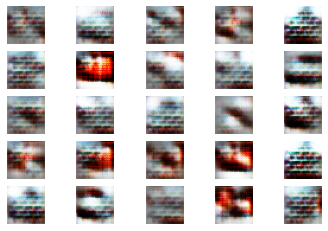

>16, 1/39, d1=0.278, d2=0.299 g=1.951
>16, 2/39, d1=0.353, d2=0.649 g=2.378
>16, 3/39, d1=0.732, d2=0.322 g=1.932
>16, 4/39, d1=0.556, d2=0.669 g=1.871
>16, 5/39, d1=0.703, d2=0.330 g=1.660
>16, 6/39, d1=0.584, d2=0.580 g=1.495
>16, 7/39, d1=0.476, d2=0.529 g=1.697
>16, 8/39, d1=0.594, d2=0.429 g=1.611
>16, 9/39, d1=0.544, d2=0.445 g=1.612
>16, 10/39, d1=0.481, d2=0.404 g=1.828
>16, 11/39, d1=0.589, d2=0.420 g=1.814
>16, 12/39, d1=0.437, d2=0.427 g=1.866
>16, 13/39, d1=0.584, d2=0.363 g=1.887
>16, 14/39, d1=0.456, d2=0.415 g=1.886
>16, 15/39, d1=0.343, d2=0.457 g=1.913
>16, 16/39, d1=0.458, d2=0.343 g=1.975
>16, 17/39, d1=0.457, d2=0.522 g=2.021
>16, 18/39, d1=0.405, d2=0.356 g=2.008
>16, 19/39, d1=0.458, d2=0.517 g=2.027
>16, 20/39, d1=0.440, d2=0.429 g=1.936
>16, 21/39, d1=0.508, d2=0.424 g=1.916
>16, 22/39, d1=0.496, d2=0.473 g=1.913
>16, 23/39, d1=0.321, d2=0.312 g=2.232
>16, 24/39, d1=0.422, d2=0.304 g=2.144
>16, 25/39, d1=0.325, d2=0.817 g=2.744
>16, 26/39, d1=1.175, d2=0.477 g=1

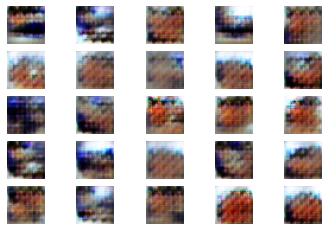

>21, 1/39, d1=0.388, d2=0.536 g=1.666
>21, 2/39, d1=0.589, d2=0.569 g=1.593
>21, 3/39, d1=0.607, d2=0.674 g=1.495
>21, 4/39, d1=0.527, d2=0.551 g=1.356
>21, 5/39, d1=0.575, d2=0.708 g=1.348
>21, 6/39, d1=0.605, d2=0.507 g=1.295
>21, 7/39, d1=0.557, d2=0.580 g=1.281
>21, 8/39, d1=0.460, d2=0.522 g=1.345
>21, 9/39, d1=0.380, d2=0.475 g=1.501
>21, 10/39, d1=0.362, d2=0.397 g=1.652
>21, 11/39, d1=0.333, d2=0.498 g=1.813
>21, 12/39, d1=0.283, d2=0.372 g=1.872
>21, 13/39, d1=0.338, d2=0.382 g=1.846
>21, 14/39, d1=0.369, d2=0.496 g=1.939
>21, 15/39, d1=0.320, d2=0.312 g=2.051
>21, 16/39, d1=0.400, d2=0.343 g=1.985
>21, 17/39, d1=0.229, d2=0.370 g=2.447
>21, 18/39, d1=0.612, d2=0.316 g=2.133
>21, 19/39, d1=0.616, d2=0.875 g=2.254
>21, 20/39, d1=0.858, d2=0.253 g=1.954
>21, 21/39, d1=0.684, d2=0.406 g=1.549
>21, 22/39, d1=0.412, d2=0.581 g=1.625
>21, 23/39, d1=0.412, d2=0.435 g=1.832
>21, 24/39, d1=0.546, d2=0.395 g=1.826
>21, 25/39, d1=0.746, d2=0.635 g=1.713
>21, 26/39, d1=0.608, d2=0.517 g=1

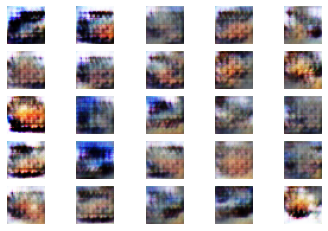

>26, 1/39, d1=0.434, d2=0.650 g=1.485
>26, 2/39, d1=0.338, d2=0.413 g=1.575
>26, 3/39, d1=0.355, d2=0.748 g=1.846
>26, 4/39, d1=0.527, d2=0.394 g=1.638
>26, 5/39, d1=0.497, d2=0.739 g=1.783
>26, 6/39, d1=0.454, d2=0.405 g=1.974
>26, 7/39, d1=0.527, d2=0.272 g=1.917
>26, 8/39, d1=0.409, d2=0.586 g=2.547
>26, 9/39, d1=0.581, d2=0.233 g=2.197
>26, 10/39, d1=0.314, d2=0.344 g=1.802
>26, 11/39, d1=0.321, d2=0.511 g=1.931
>26, 12/39, d1=0.320, d2=0.420 g=2.140
>26, 13/39, d1=0.411, d2=0.482 g=2.159
>26, 14/39, d1=0.517, d2=0.766 g=2.123
>26, 15/39, d1=0.689, d2=0.340 g=1.763
>26, 16/39, d1=0.573, d2=1.151 g=2.044
>26, 17/39, d1=1.038, d2=0.283 g=1.775
>26, 18/39, d1=0.960, d2=0.554 g=1.403
>26, 19/39, d1=0.400, d2=0.742 g=1.635
>26, 20/39, d1=0.483, d2=0.308 g=1.654
>26, 21/39, d1=0.440, d2=0.400 g=1.654
>26, 22/39, d1=0.464, d2=0.522 g=1.632
>26, 23/39, d1=0.361, d2=0.409 g=1.718
>26, 24/39, d1=0.379, d2=0.350 g=1.635
>26, 25/39, d1=0.419, d2=0.595 g=1.712
>26, 26/39, d1=0.496, d2=0.500 g=1

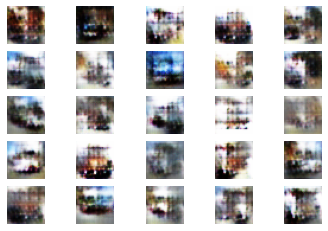

>31, 1/39, d1=0.283, d2=0.270 g=1.818
>31, 2/39, d1=0.401, d2=0.568 g=1.553
>31, 3/39, d1=0.317, d2=0.524 g=1.802
>31, 4/39, d1=0.414, d2=0.505 g=1.952
>31, 5/39, d1=0.516, d2=0.482 g=2.089
>31, 6/39, d1=0.505, d2=0.397 g=1.877
>31, 7/39, d1=0.379, d2=0.488 g=1.893
>31, 8/39, d1=0.293, d2=0.370 g=1.959
>31, 9/39, d1=0.327, d2=0.589 g=2.069
>31, 10/39, d1=0.675, d2=0.520 g=1.960
>31, 11/39, d1=0.505, d2=0.741 g=2.187
>31, 12/39, d1=0.826, d2=0.440 g=2.018
>31, 13/39, d1=0.529, d2=0.581 g=1.971
>31, 14/39, d1=0.535, d2=0.318 g=2.058
>31, 15/39, d1=0.500, d2=0.479 g=2.056
>31, 16/39, d1=0.402, d2=0.385 g=2.193
>31, 17/39, d1=0.480, d2=0.339 g=1.936
>31, 18/39, d1=0.385, d2=0.793 g=2.101
>31, 19/39, d1=0.539, d2=0.469 g=2.099
>31, 20/39, d1=0.670, d2=0.591 g=1.673
>31, 21/39, d1=0.476, d2=0.737 g=1.952
>31, 22/39, d1=0.815, d2=0.612 g=1.966
>31, 23/39, d1=0.711, d2=0.520 g=2.175
>31, 24/39, d1=0.530, d2=0.449 g=2.271
>31, 25/39, d1=0.486, d2=0.332 g=2.103
>31, 26/39, d1=0.316, d2=0.544 g=2

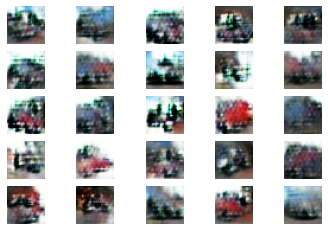

>36, 1/39, d1=0.347, d2=0.511 g=1.654
>36, 2/39, d1=0.389, d2=0.475 g=1.513
>36, 3/39, d1=0.485, d2=0.631 g=1.569
>36, 4/39, d1=0.517, d2=0.535 g=1.744
>36, 5/39, d1=0.829, d2=0.566 g=1.575
>36, 6/39, d1=0.447, d2=0.430 g=1.638
>36, 7/39, d1=0.621, d2=0.521 g=1.695
>36, 8/39, d1=0.608, d2=0.493 g=1.716
>36, 9/39, d1=0.551, d2=0.600 g=1.663
>36, 10/39, d1=0.587, d2=0.627 g=1.854
>36, 11/39, d1=0.865, d2=0.486 g=1.615
>36, 12/39, d1=0.706, d2=0.454 g=1.536
>36, 13/39, d1=0.692, d2=0.617 g=1.600
>36, 14/39, d1=0.415, d2=0.391 g=1.717
>36, 15/39, d1=0.537, d2=0.495 g=1.710
>36, 16/39, d1=0.458, d2=0.400 g=1.749
>36, 17/39, d1=0.538, d2=0.527 g=1.590
>36, 18/39, d1=0.469, d2=0.525 g=1.697
>36, 19/39, d1=0.558, d2=0.598 g=1.616
>36, 20/39, d1=0.575, d2=0.404 g=1.595
>36, 21/39, d1=0.366, d2=0.368 g=1.651
>36, 22/39, d1=0.453, d2=0.541 g=1.785
>36, 23/39, d1=0.486, d2=0.451 g=1.764
>36, 24/39, d1=0.488, d2=0.403 g=1.808
>36, 25/39, d1=0.398, d2=0.444 g=1.795
>36, 26/39, d1=0.644, d2=0.447 g=1

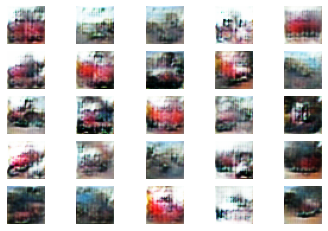

>41, 1/39, d1=0.256, d2=0.397 g=1.807
>41, 2/39, d1=0.388, d2=0.488 g=1.917
>41, 3/39, d1=0.518, d2=0.302 g=1.749
>41, 4/39, d1=0.388, d2=0.530 g=1.816
>41, 5/39, d1=0.529, d2=0.404 g=1.884
>41, 6/39, d1=0.377, d2=0.444 g=1.980
>41, 7/39, d1=0.382, d2=0.420 g=2.017
>41, 8/39, d1=0.428, d2=0.291 g=1.964
>41, 9/39, d1=0.371, d2=0.661 g=2.109
>41, 10/39, d1=0.510, d2=0.334 g=2.053
>41, 11/39, d1=0.547, d2=0.513 g=1.954
>41, 12/39, d1=0.372, d2=0.422 g=1.940
>41, 13/39, d1=0.435, d2=0.447 g=2.220
>41, 14/39, d1=0.523, d2=0.535 g=2.195
>41, 15/39, d1=0.721, d2=0.741 g=2.218
>41, 16/39, d1=0.540, d2=0.405 g=1.910
>41, 17/39, d1=0.496, d2=0.659 g=2.142
>41, 18/39, d1=0.571, d2=0.333 g=1.890
>41, 19/39, d1=0.546, d2=0.610 g=1.859
>41, 20/39, d1=0.562, d2=0.396 g=1.897
>41, 21/39, d1=0.519, d2=0.520 g=1.908
>41, 22/39, d1=0.556, d2=0.428 g=1.736
>41, 23/39, d1=0.438, d2=0.421 g=1.848
>41, 24/39, d1=0.447, d2=0.471 g=1.872
>41, 25/39, d1=0.478, d2=0.423 g=2.128
>41, 26/39, d1=0.462, d2=0.344 g=2

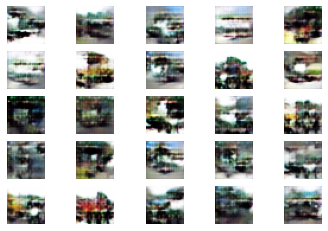

>46, 1/39, d1=0.272, d2=0.445 g=2.005
>46, 2/39, d1=0.517, d2=0.350 g=2.017
>46, 3/39, d1=0.366, d2=0.365 g=1.774
>46, 4/39, d1=0.368, d2=0.515 g=1.948
>46, 5/39, d1=0.564, d2=0.543 g=1.940
>46, 6/39, d1=0.633, d2=0.532 g=1.886
>46, 7/39, d1=0.502, d2=0.506 g=1.972
>46, 8/39, d1=0.547, d2=0.393 g=1.943
>46, 9/39, d1=0.492, d2=0.450 g=2.131
>46, 10/39, d1=0.372, d2=0.241 g=2.410
>46, 11/39, d1=0.424, d2=0.278 g=2.245
>46, 12/39, d1=0.235, d2=0.399 g=2.403
>46, 13/39, d1=0.350, d2=0.530 g=2.510
>46, 14/39, d1=0.534, d2=0.563 g=2.332
>46, 15/39, d1=0.566, d2=0.403 g=2.191
>46, 16/39, d1=0.531, d2=0.519 g=2.163
>46, 17/39, d1=0.452, d2=0.328 g=1.985
>46, 18/39, d1=0.328, d2=0.451 g=1.839
>46, 19/39, d1=0.429, d2=0.445 g=1.947
>46, 20/39, d1=0.545, d2=0.448 g=1.802
>46, 21/39, d1=0.459, d2=0.863 g=1.975
>46, 22/39, d1=0.597, d2=0.377 g=1.898
>46, 23/39, d1=0.567, d2=0.667 g=1.796
>46, 24/39, d1=0.740, d2=0.517 g=1.877
>46, 25/39, d1=0.867, d2=0.462 g=1.701
>46, 26/39, d1=0.605, d2=0.493 g=1

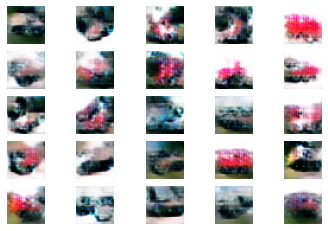

>51, 1/39, d1=0.307, d2=0.434 g=1.904
>51, 2/39, d1=0.627, d2=0.565 g=1.715
>51, 3/39, d1=0.501, d2=0.398 g=2.020
>51, 4/39, d1=0.519, d2=0.367 g=2.170
>51, 5/39, d1=0.483, d2=0.413 g=2.197
>51, 6/39, d1=0.298, d2=0.524 g=2.268
>51, 7/39, d1=0.550, d2=0.454 g=2.049
>51, 8/39, d1=0.594, d2=0.692 g=2.166
>51, 9/39, d1=0.425, d2=0.283 g=2.097
>51, 10/39, d1=0.494, d2=0.602 g=2.332
>51, 11/39, d1=0.476, d2=0.375 g=2.279
>51, 12/39, d1=0.681, d2=0.462 g=1.977
>51, 13/39, d1=0.362, d2=0.433 g=2.388
>51, 14/39, d1=0.583, d2=0.441 g=2.384
>51, 15/39, d1=0.739, d2=0.384 g=2.055
>51, 16/39, d1=0.542, d2=0.461 g=2.024
>51, 17/39, d1=0.422, d2=0.352 g=1.928
>51, 18/39, d1=0.276, d2=0.630 g=2.383
>51, 19/39, d1=0.481, d2=0.496 g=2.320
>51, 20/39, d1=0.640, d2=0.405 g=1.706
>51, 21/39, d1=0.404, d2=0.480 g=1.745
>51, 22/39, d1=0.472, d2=0.363 g=1.808
>51, 23/39, d1=0.398, d2=0.374 g=2.171
>51, 24/39, d1=0.316, d2=0.523 g=2.003
>51, 25/39, d1=0.533, d2=0.498 g=1.888
>51, 26/39, d1=0.502, d2=0.515 g=2

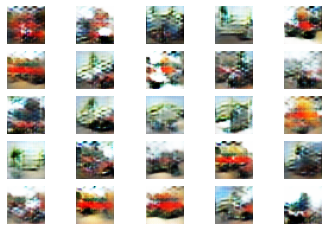

>56, 1/39, d1=0.539, d2=0.566 g=1.275
>56, 2/39, d1=0.611, d2=0.686 g=1.058
>56, 3/39, d1=0.658, d2=0.847 g=1.222
>56, 4/39, d1=0.734, d2=0.701 g=1.195
>56, 5/39, d1=0.630, d2=0.644 g=1.292
>56, 6/39, d1=0.782, d2=0.663 g=1.210
>56, 7/39, d1=0.750, d2=0.533 g=1.282
>56, 8/39, d1=0.752, d2=0.636 g=1.217
>56, 9/39, d1=0.689, d2=0.555 g=1.266
>56, 10/39, d1=0.669, d2=0.569 g=1.337
>56, 11/39, d1=0.654, d2=0.485 g=1.296
>56, 12/39, d1=0.678, d2=0.440 g=1.303
>56, 13/39, d1=0.550, d2=0.582 g=1.431
>56, 14/39, d1=0.601, d2=0.555 g=1.531
>56, 15/39, d1=0.605, d2=0.427 g=1.490
>56, 16/39, d1=0.620, d2=0.509 g=1.396
>56, 17/39, d1=0.595, d2=0.553 g=1.507
>56, 18/39, d1=0.609, d2=0.486 g=1.503
>56, 19/39, d1=0.583, d2=0.442 g=1.421
>56, 20/39, d1=0.594, d2=0.432 g=1.298
>56, 21/39, d1=0.478, d2=0.664 g=1.310
>56, 22/39, d1=0.426, d2=0.542 g=1.432
>56, 23/39, d1=0.581, d2=0.490 g=1.398
>56, 24/39, d1=0.481, d2=0.621 g=1.346
>56, 25/39, d1=0.444, d2=0.675 g=1.529
>56, 26/39, d1=0.701, d2=0.591 g=1

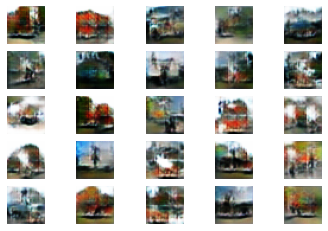

>61, 1/39, d1=0.315, d2=0.512 g=1.611
>61, 2/39, d1=0.523, d2=0.503 g=1.726
>61, 3/39, d1=0.645, d2=0.429 g=1.629
>61, 4/39, d1=0.559, d2=0.470 g=1.683
>61, 5/39, d1=0.498, d2=0.450 g=1.587
>61, 6/39, d1=0.422, d2=0.364 g=1.563
>61, 7/39, d1=0.366, d2=0.693 g=1.707
>61, 8/39, d1=0.479, d2=0.596 g=1.754
>61, 9/39, d1=0.605, d2=0.489 g=1.629
>61, 10/39, d1=0.666, d2=0.384 g=1.422
>61, 11/39, d1=0.402, d2=0.648 g=1.636
>61, 12/39, d1=0.478, d2=0.499 g=1.756
>61, 13/39, d1=0.549, d2=0.511 g=1.666
>61, 14/39, d1=0.681, d2=0.531 g=1.581
>61, 15/39, d1=0.779, d2=0.554 g=1.649
>61, 16/39, d1=0.582, d2=0.300 g=1.629
>61, 17/39, d1=0.591, d2=0.486 g=1.437
>61, 18/39, d1=0.491, d2=0.651 g=1.590
>61, 19/39, d1=0.528, d2=0.482 g=1.609
>61, 20/39, d1=0.545, d2=0.486 g=1.593
>61, 21/39, d1=0.525, d2=0.507 g=1.654
>61, 22/39, d1=0.594, d2=0.533 g=1.615
>61, 23/39, d1=0.601, d2=0.590 g=1.680
>61, 24/39, d1=0.646, d2=0.522 g=1.660
>61, 25/39, d1=0.569, d2=0.439 g=1.455
>61, 26/39, d1=0.542, d2=0.561 g=1

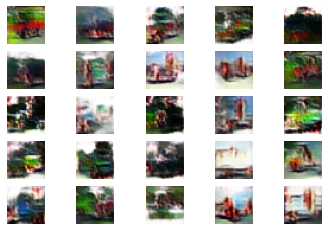

>66, 1/39, d1=0.326, d2=0.579 g=1.722
>66, 2/39, d1=0.451, d2=0.497 g=1.824
>66, 3/39, d1=0.480, d2=0.412 g=1.642
>66, 4/39, d1=0.435, d2=0.402 g=1.584
>66, 5/39, d1=0.422, d2=0.479 g=1.574
>66, 6/39, d1=0.410, d2=0.653 g=1.786
>66, 7/39, d1=0.439, d2=0.495 g=1.802
>66, 8/39, d1=0.472, d2=0.580 g=1.706
>66, 9/39, d1=0.636, d2=0.884 g=1.940
>66, 10/39, d1=0.792, d2=0.344 g=1.714
>66, 11/39, d1=0.614, d2=0.811 g=1.784
>66, 12/39, d1=0.581, d2=0.314 g=1.712
>66, 13/39, d1=0.529, d2=0.453 g=1.612
>66, 14/39, d1=0.402, d2=0.470 g=1.603
>66, 15/39, d1=0.276, d2=0.481 g=1.866
>66, 16/39, d1=0.522, d2=0.514 g=1.697
>66, 17/39, d1=0.345, d2=0.404 g=1.714
>66, 18/39, d1=0.497, d2=0.402 g=1.687
>66, 19/39, d1=0.701, d2=0.636 g=1.573
>66, 20/39, d1=0.438, d2=0.503 g=1.890
>66, 21/39, d1=0.648, d2=0.463 g=1.730
>66, 22/39, d1=0.632, d2=0.368 g=1.706
>66, 23/39, d1=0.518, d2=0.485 g=1.519
>66, 24/39, d1=0.352, d2=0.473 g=1.678
>66, 25/39, d1=0.370, d2=0.475 g=1.946
>66, 26/39, d1=0.716, d2=0.625 g=1

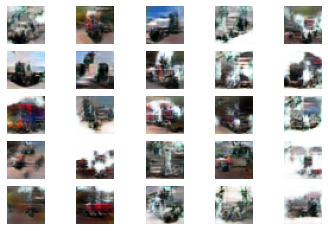

>71, 1/39, d1=0.322, d2=0.484 g=1.691
>71, 2/39, d1=0.546, d2=0.474 g=1.664
>71, 3/39, d1=0.436, d2=0.478 g=1.644
>71, 4/39, d1=0.550, d2=0.438 g=1.550
>71, 5/39, d1=0.504, d2=0.456 g=1.615
>71, 6/39, d1=0.423, d2=0.430 g=1.665
>71, 7/39, d1=0.437, d2=0.536 g=1.630
>71, 8/39, d1=0.601, d2=0.461 g=1.664
>71, 9/39, d1=0.597, d2=0.509 g=1.585
>71, 10/39, d1=0.495, d2=0.455 g=1.525
>71, 11/39, d1=0.473, d2=0.528 g=1.526
>71, 12/39, d1=0.497, d2=0.561 g=1.552
>71, 13/39, d1=0.519, d2=0.368 g=1.580
>71, 14/39, d1=0.470, d2=0.624 g=1.714
>71, 15/39, d1=0.629, d2=0.486 g=1.595
>71, 16/39, d1=0.571, d2=0.508 g=1.499
>71, 17/39, d1=0.334, d2=0.526 g=1.612
>71, 18/39, d1=0.558, d2=0.487 g=1.511
>71, 19/39, d1=0.487, d2=0.603 g=1.564
>71, 20/39, d1=0.522, d2=0.585 g=1.672
>71, 21/39, d1=0.550, d2=0.479 g=1.643
>71, 22/39, d1=0.458, d2=0.500 g=1.759
>71, 23/39, d1=0.444, d2=0.438 g=1.727
>71, 24/39, d1=0.584, d2=0.415 g=1.923
>71, 25/39, d1=0.537, d2=0.431 g=2.006
>71, 26/39, d1=0.529, d2=0.385 g=2

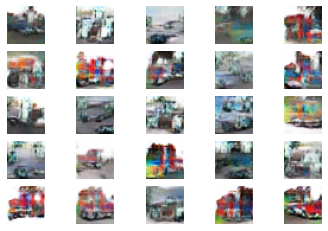

>76, 1/39, d1=0.354, d2=0.579 g=1.486
>76, 2/39, d1=0.519, d2=0.574 g=1.544
>76, 3/39, d1=0.506, d2=0.467 g=1.601
>76, 4/39, d1=0.644, d2=0.402 g=1.558
>76, 5/39, d1=0.566, d2=0.498 g=1.504
>76, 6/39, d1=0.382, d2=0.438 g=1.600
>76, 7/39, d1=0.500, d2=0.440 g=1.601
>76, 8/39, d1=0.454, d2=0.447 g=1.466
>76, 9/39, d1=0.545, d2=0.586 g=1.579
>76, 10/39, d1=0.348, d2=0.407 g=1.640
>76, 11/39, d1=0.441, d2=0.405 g=1.506
>76, 12/39, d1=0.361, d2=0.469 g=1.652
>76, 13/39, d1=0.505, d2=0.564 g=1.700
>76, 14/39, d1=0.604, d2=0.465 g=1.690
>76, 15/39, d1=0.533, d2=0.545 g=1.729
>76, 16/39, d1=0.554, d2=0.550 g=1.703
>76, 17/39, d1=0.556, d2=0.443 g=1.830
>76, 18/39, d1=0.433, d2=0.581 g=1.902
>76, 19/39, d1=0.518, d2=0.445 g=1.887
>76, 20/39, d1=0.569, d2=0.588 g=2.057
>76, 21/39, d1=0.764, d2=0.390 g=1.722
>76, 22/39, d1=0.529, d2=0.587 g=1.831
>76, 23/39, d1=0.460, d2=0.297 g=1.717
>76, 24/39, d1=0.405, d2=0.434 g=1.510
>76, 25/39, d1=0.288, d2=0.809 g=1.696
>76, 26/39, d1=0.453, d2=0.407 g=1

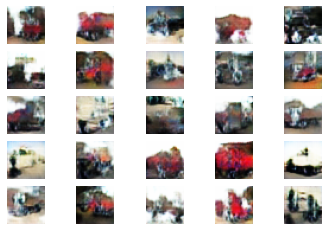

>81, 1/39, d1=0.408, d2=0.521 g=1.561
>81, 2/39, d1=0.491, d2=0.626 g=1.459
>81, 3/39, d1=0.715, d2=0.744 g=1.512
>81, 4/39, d1=0.857, d2=0.665 g=1.686
>81, 5/39, d1=0.752, d2=0.282 g=1.754
>81, 6/39, d1=0.672, d2=0.392 g=1.639
>81, 7/39, d1=0.498, d2=0.473 g=1.635
>81, 8/39, d1=0.438, d2=0.528 g=1.484
>81, 9/39, d1=0.458, d2=0.553 g=1.582
>81, 10/39, d1=0.590, d2=0.439 g=1.517
>81, 11/39, d1=0.600, d2=0.503 g=1.466
>81, 12/39, d1=0.763, d2=0.705 g=1.539
>81, 13/39, d1=0.593, d2=0.397 g=1.508
>81, 14/39, d1=0.665, d2=0.473 g=1.532
>81, 15/39, d1=0.548, d2=0.456 g=1.515
>81, 16/39, d1=0.484, d2=0.454 g=1.507
>81, 17/39, d1=0.559, d2=0.521 g=1.435
>81, 18/39, d1=0.485, d2=0.512 g=1.486
>81, 19/39, d1=0.534, d2=0.540 g=1.465
>81, 20/39, d1=0.400, d2=0.433 g=1.473
>81, 21/39, d1=0.481, d2=0.504 g=1.460
>81, 22/39, d1=0.396, d2=0.729 g=1.786
>81, 23/39, d1=0.566, d2=0.407 g=1.771
>81, 24/39, d1=0.579, d2=0.483 g=1.597
>81, 25/39, d1=0.554, d2=0.533 g=1.457
>81, 26/39, d1=0.410, d2=0.411 g=1

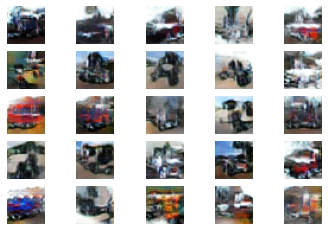

>86, 1/39, d1=0.295, d2=0.496 g=1.922
>86, 2/39, d1=0.698, d2=0.444 g=1.714
>86, 3/39, d1=0.633, d2=0.503 g=1.561
>86, 4/39, d1=0.526, d2=0.527 g=1.644
>86, 5/39, d1=0.431, d2=0.491 g=1.792
>86, 6/39, d1=0.651, d2=0.498 g=1.674
>86, 7/39, d1=0.507, d2=0.530 g=1.704
>86, 8/39, d1=0.406, d2=0.412 g=1.756
>86, 9/39, d1=0.515, d2=0.366 g=1.630
>86, 10/39, d1=0.458, d2=0.535 g=1.687
>86, 11/39, d1=0.573, d2=0.611 g=1.579
>86, 12/39, d1=0.508, d2=0.452 g=1.538
>86, 13/39, d1=0.530, d2=0.436 g=1.547
>86, 14/39, d1=0.529, d2=0.592 g=1.608
>86, 15/39, d1=0.449, d2=0.393 g=1.759
>86, 16/39, d1=0.490, d2=0.545 g=1.766
>86, 17/39, d1=0.374, d2=0.457 g=1.936
>86, 18/39, d1=0.592, d2=0.372 g=1.876
>86, 19/39, d1=0.390, d2=0.343 g=1.908
>86, 20/39, d1=0.476, d2=0.441 g=1.717
>86, 21/39, d1=0.373, d2=0.456 g=1.899
>86, 22/39, d1=0.520, d2=0.720 g=2.084
>86, 23/39, d1=0.664, d2=0.254 g=1.891
>86, 24/39, d1=0.532, d2=0.611 g=1.786
>86, 25/39, d1=0.616, d2=0.363 g=1.710
>86, 26/39, d1=0.580, d2=0.458 g=1

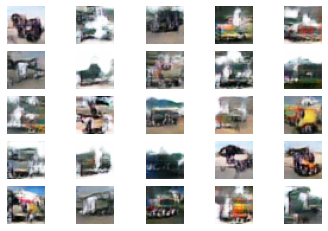

>91, 1/39, d1=0.286, d2=0.427 g=1.998
>91, 2/39, d1=0.518, d2=0.466 g=1.900
>91, 3/39, d1=0.427, d2=0.463 g=1.801
>91, 4/39, d1=0.607, d2=0.689 g=1.892
>91, 5/39, d1=0.542, d2=0.369 g=1.851
>91, 6/39, d1=0.514, d2=0.523 g=1.919
>91, 7/39, d1=0.539, d2=0.414 g=1.974
>91, 8/39, d1=0.583, d2=0.449 g=1.901
>91, 9/39, d1=0.506, d2=0.501 g=1.964
>91, 10/39, d1=0.525, d2=0.323 g=1.971
>91, 11/39, d1=0.518, d2=0.594 g=2.422
>91, 12/39, d1=0.546, d2=0.266 g=2.189
>91, 13/39, d1=0.521, d2=0.675 g=2.225
>91, 14/39, d1=0.674, d2=0.396 g=1.882
>91, 15/39, d1=0.765, d2=0.514 g=1.629
>91, 16/39, d1=0.716, d2=0.494 g=1.464
>91, 17/39, d1=0.462, d2=0.630 g=1.561
>91, 18/39, d1=0.443, d2=0.351 g=1.601
>91, 19/39, d1=0.410, d2=0.553 g=1.728
>91, 20/39, d1=0.316, d2=0.378 g=1.801
>91, 21/39, d1=0.439, d2=0.472 g=1.947
>91, 22/39, d1=0.376, d2=0.360 g=1.990
>91, 23/39, d1=0.387, d2=0.566 g=2.142
>91, 24/39, d1=0.509, d2=0.289 g=2.068
>91, 25/39, d1=0.381, d2=0.569 g=2.364
>91, 26/39, d1=0.586, d2=0.446 g=2

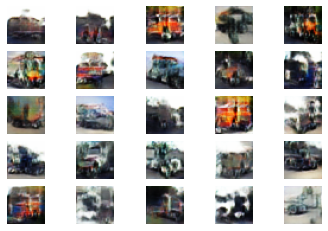

>96, 1/39, d1=0.314, d2=0.385 g=1.496
>96, 2/39, d1=0.505, d2=0.781 g=1.849
>96, 3/39, d1=0.640, d2=0.321 g=1.888
>96, 4/39, d1=0.493, d2=0.392 g=1.750
>96, 5/39, d1=0.452, d2=0.416 g=1.570
>96, 6/39, d1=0.383, d2=0.530 g=1.845
>96, 7/39, d1=0.510, d2=0.265 g=1.702
>96, 8/39, d1=0.388, d2=0.611 g=1.781
>96, 9/39, d1=0.463, d2=0.444 g=1.947
>96, 10/39, d1=0.510, d2=0.463 g=1.974
>96, 11/39, d1=0.451, d2=0.374 g=1.988
>96, 12/39, d1=0.254, d2=0.318 g=1.922
>96, 13/39, d1=0.429, d2=0.469 g=1.869
>96, 14/39, d1=0.586, d2=0.349 g=1.784
>96, 15/39, d1=0.445, d2=0.823 g=2.003
>96, 16/39, d1=0.637, d2=0.314 g=1.824
>96, 17/39, d1=0.443, d2=0.457 g=1.794
>96, 18/39, d1=0.438, d2=0.406 g=1.689
>96, 19/39, d1=0.319, d2=0.496 g=1.958
>96, 20/39, d1=0.472, d2=0.293 g=1.884
>96, 21/39, d1=0.384, d2=0.551 g=1.845
>96, 22/39, d1=0.434, d2=0.315 g=1.954
>96, 23/39, d1=0.433, d2=0.534 g=1.944
>96, 24/39, d1=0.552, d2=0.348 g=1.893
>96, 25/39, d1=0.491, d2=0.562 g=1.776
>96, 26/39, d1=0.462, d2=0.462 g=2

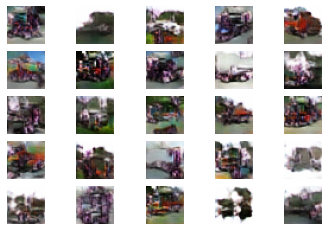

>101, 1/39, d1=0.278, d2=0.436 g=1.854
>101, 2/39, d1=0.432, d2=0.463 g=1.909
>101, 3/39, d1=0.416, d2=0.447 g=2.117
>101, 4/39, d1=0.470, d2=0.467 g=2.074
>101, 5/39, d1=0.469, d2=0.538 g=2.060
>101, 6/39, d1=0.493, d2=0.281 g=2.067
>101, 7/39, d1=0.556, d2=0.535 g=1.963
>101, 8/39, d1=0.555, d2=0.617 g=1.865
>101, 9/39, d1=0.600, d2=0.423 g=1.743
>101, 10/39, d1=0.648, d2=0.372 g=1.709
>101, 11/39, d1=0.455, d2=0.694 g=2.074
>101, 12/39, d1=0.658, d2=0.253 g=1.867
>101, 13/39, d1=0.580, d2=0.551 g=1.573
>101, 14/39, d1=0.298, d2=0.740 g=1.794
>101, 15/39, d1=0.619, d2=0.442 g=1.750
>101, 16/39, d1=0.471, d2=0.401 g=1.740
>101, 17/39, d1=0.407, d2=0.423 g=1.788
>101, 18/39, d1=0.414, d2=0.551 g=2.120
>101, 19/39, d1=0.543, d2=0.333 g=1.943
>101, 20/39, d1=0.612, d2=0.471 g=1.860
>101, 21/39, d1=0.535, d2=0.632 g=1.842
>101, 22/39, d1=0.627, d2=0.361 g=1.647
>101, 23/39, d1=0.499, d2=0.490 g=1.450
>101, 24/39, d1=0.461, d2=0.498 g=1.812
>101, 25/39, d1=0.512, d2=0.447 g=1.832
>101, 26/

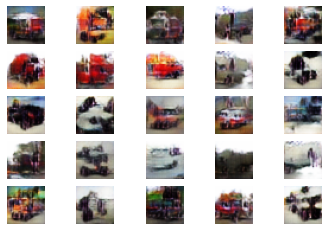

>106, 1/39, d1=0.242, d2=0.388 g=2.088
>106, 2/39, d1=0.348, d2=0.515 g=2.176
>106, 3/39, d1=0.434, d2=0.300 g=2.121
>106, 4/39, d1=0.336, d2=0.303 g=1.939
>106, 5/39, d1=0.310, d2=0.594 g=2.323
>106, 6/39, d1=0.443, d2=0.424 g=2.414
>106, 7/39, d1=0.684, d2=0.252 g=1.949
>106, 8/39, d1=0.422, d2=0.510 g=2.153
>106, 9/39, d1=0.317, d2=0.366 g=2.341
>106, 10/39, d1=0.693, d2=0.436 g=1.927
>106, 11/39, d1=0.331, d2=0.607 g=2.051
>106, 12/39, d1=0.704, d2=0.451 g=1.996
>106, 13/39, d1=0.590, d2=0.366 g=1.824
>106, 14/39, d1=0.353, d2=0.446 g=1.798
>106, 15/39, d1=0.386, d2=0.314 g=1.850
>106, 16/39, d1=0.435, d2=0.502 g=2.045
>106, 17/39, d1=0.501, d2=0.380 g=1.918
>106, 18/39, d1=0.596, d2=0.492 g=1.939
>106, 19/39, d1=0.415, d2=0.334 g=1.903
>106, 20/39, d1=0.419, d2=0.602 g=2.285
>106, 21/39, d1=0.546, d2=0.305 g=1.996
>106, 22/39, d1=0.551, d2=0.543 g=1.905
>106, 23/39, d1=0.366, d2=0.390 g=1.986
>106, 24/39, d1=0.423, d2=0.334 g=2.104
>106, 25/39, d1=0.493, d2=0.442 g=2.204
>106, 26/

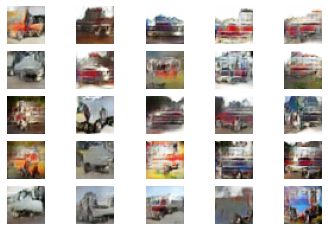

>111, 1/39, d1=0.242, d2=0.332 g=1.918
>111, 2/39, d1=0.510, d2=0.446 g=1.764
>111, 3/39, d1=0.376, d2=0.617 g=2.149
>111, 4/39, d1=0.567, d2=0.492 g=2.036
>111, 5/39, d1=0.563, d2=0.314 g=1.845
>111, 6/39, d1=0.443, d2=0.531 g=1.878
>111, 7/39, d1=0.466, d2=0.451 g=2.010
>111, 8/39, d1=0.546, d2=0.370 g=1.819
>111, 9/39, d1=0.558, d2=0.500 g=1.895
>111, 10/39, d1=0.362, d2=0.285 g=2.025
>111, 11/39, d1=0.320, d2=0.580 g=1.946
>111, 12/39, d1=0.422, d2=0.571 g=2.184
>111, 13/39, d1=0.684, d2=0.283 g=1.980
>111, 14/39, d1=0.558, d2=0.673 g=1.756
>111, 15/39, d1=0.410, d2=0.418 g=2.082
>111, 16/39, d1=0.449, d2=0.289 g=2.068
>111, 17/39, d1=0.404, d2=0.383 g=1.922
>111, 18/39, d1=0.380, d2=0.431 g=1.869
>111, 19/39, d1=0.398, d2=0.636 g=2.294
>111, 20/39, d1=0.659, d2=0.310 g=2.063
>111, 21/39, d1=0.458, d2=0.392 g=2.103
>111, 22/39, d1=0.363, d2=0.467 g=2.199
>111, 23/39, d1=0.398, d2=0.287 g=2.220
>111, 24/39, d1=0.586, d2=0.347 g=1.946
>111, 25/39, d1=0.316, d2=0.538 g=2.120
>111, 26/

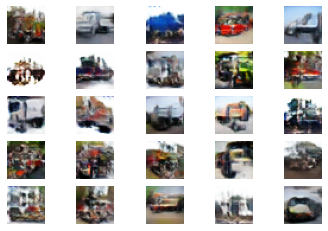

>116, 1/39, d1=0.214, d2=0.690 g=2.277
>116, 2/39, d1=0.693, d2=0.284 g=2.078
>116, 3/39, d1=0.519, d2=0.532 g=1.963
>116, 4/39, d1=0.438, d2=0.567 g=2.081
>116, 5/39, d1=0.476, d2=0.314 g=2.014
>116, 6/39, d1=0.529, d2=0.483 g=1.794
>116, 7/39, d1=0.490, d2=0.447 g=1.967
>116, 8/39, d1=0.589, d2=0.433 g=2.017
>116, 9/39, d1=0.532, d2=0.455 g=1.765
>116, 10/39, d1=0.538, d2=0.575 g=2.146
>116, 11/39, d1=0.662, d2=0.376 g=1.843
>116, 12/39, d1=0.577, d2=0.527 g=1.753
>116, 13/39, d1=0.591, d2=0.393 g=1.766
>116, 14/39, d1=0.559, d2=0.482 g=1.639
>116, 15/39, d1=0.368, d2=0.472 g=1.938
>116, 16/39, d1=0.556, d2=0.349 g=1.706
>116, 17/39, d1=0.389, d2=0.593 g=1.808
>116, 18/39, d1=0.514, d2=0.559 g=1.925
>116, 19/39, d1=0.597, d2=0.324 g=1.640
>116, 20/39, d1=0.435, d2=0.492 g=1.698
>116, 21/39, d1=0.556, d2=0.439 g=1.791
>116, 22/39, d1=0.500, d2=0.405 g=1.780
>116, 23/39, d1=0.449, d2=0.358 g=1.822
>116, 24/39, d1=0.432, d2=0.446 g=1.782
>116, 25/39, d1=0.436, d2=0.517 g=2.063
>116, 26/

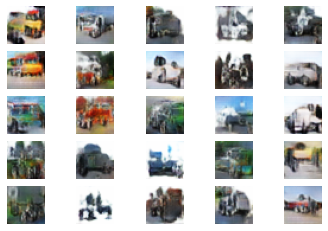

>121, 1/39, d1=0.287, d2=0.424 g=1.871
>121, 2/39, d1=0.398, d2=0.373 g=1.743
>121, 3/39, d1=0.425, d2=0.413 g=1.837
>121, 4/39, d1=0.289, d2=0.648 g=2.161
>121, 5/39, d1=0.435, d2=0.264 g=2.020
>121, 6/39, d1=0.538, d2=0.406 g=1.845
>121, 7/39, d1=0.395, d2=0.529 g=1.925
>121, 8/39, d1=0.387, d2=0.388 g=2.040
>121, 9/39, d1=0.457, d2=0.318 g=1.846
>121, 10/39, d1=0.296, d2=0.754 g=2.442
>121, 11/39, d1=0.688, d2=0.257 g=2.060
>121, 12/39, d1=0.433, d2=0.433 g=1.855
>121, 13/39, d1=0.455, d2=0.591 g=2.151
>121, 14/39, d1=0.526, d2=0.308 g=2.153
>121, 15/39, d1=0.506, d2=0.366 g=1.912
>121, 16/39, d1=0.304, d2=0.500 g=2.125
>121, 17/39, d1=0.434, d2=0.402 g=2.071
>121, 18/39, d1=0.642, d2=0.405 g=1.814
>121, 19/39, d1=0.368, d2=0.558 g=1.955
>121, 20/39, d1=0.550, d2=0.353 g=1.830
>121, 21/39, d1=0.415, d2=0.443 g=1.779
>121, 22/39, d1=0.385, d2=0.397 g=2.050
>121, 23/39, d1=0.614, d2=0.380 g=2.142
>121, 24/39, d1=0.439, d2=0.507 g=2.165
>121, 25/39, d1=0.479, d2=0.292 g=2.196
>121, 26/

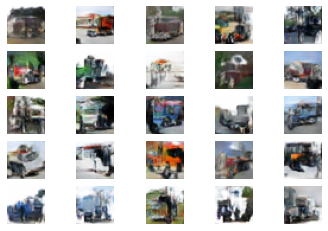

>126, 1/39, d1=0.274, d2=0.350 g=2.145
>126, 2/39, d1=0.757, d2=0.532 g=1.742
>126, 3/39, d1=0.368, d2=0.564 g=1.925
>126, 4/39, d1=0.461, d2=0.455 g=1.953
>126, 5/39, d1=0.470, d2=0.441 g=1.927
>126, 6/39, d1=0.453, d2=0.438 g=1.988
>126, 7/39, d1=0.433, d2=0.440 g=1.982
>126, 8/39, d1=0.572, d2=0.419 g=1.841
>126, 9/39, d1=0.466, d2=0.338 g=1.744
>126, 10/39, d1=0.383, d2=0.480 g=1.851
>126, 11/39, d1=0.423, d2=0.396 g=1.968
>126, 12/39, d1=0.517, d2=0.421 g=1.872
>126, 13/39, d1=0.426, d2=0.313 g=1.917
>126, 14/39, d1=0.360, d2=0.571 g=2.152
>126, 15/39, d1=0.569, d2=0.334 g=1.889
>126, 16/39, d1=0.383, d2=0.429 g=1.979
>126, 17/39, d1=0.461, d2=0.424 g=2.042
>126, 18/39, d1=0.561, d2=0.469 g=2.163
>126, 19/39, d1=0.655, d2=0.444 g=1.898
>126, 20/39, d1=0.416, d2=0.435 g=1.905
>126, 21/39, d1=0.333, d2=0.531 g=2.215
>126, 22/39, d1=0.683, d2=0.384 g=1.946
>126, 23/39, d1=0.403, d2=0.498 g=2.081
>126, 24/39, d1=0.541, d2=0.380 g=2.113
>126, 25/39, d1=0.472, d2=0.387 g=1.988
>126, 26/

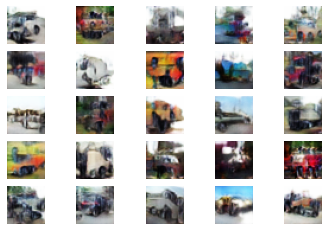

>131, 1/39, d1=0.261, d2=0.495 g=1.943
>131, 2/39, d1=0.533, d2=0.321 g=1.800
>131, 3/39, d1=0.379, d2=0.441 g=1.854
>131, 4/39, d1=0.368, d2=0.417 g=2.090
>131, 5/39, d1=0.541, d2=0.343 g=2.062
>131, 6/39, d1=0.394, d2=0.617 g=2.186
>131, 7/39, d1=0.489, d2=0.327 g=2.249
>131, 8/39, d1=0.530, d2=0.407 g=1.959
>131, 9/39, d1=0.395, d2=0.443 g=1.994
>131, 10/39, d1=0.420, d2=0.389 g=2.073
>131, 11/39, d1=0.345, d2=0.434 g=2.121
>131, 12/39, d1=0.605, d2=0.434 g=1.995
>131, 13/39, d1=0.398, d2=0.498 g=2.428
>131, 14/39, d1=0.529, d2=0.353 g=2.253
>131, 15/39, d1=0.404, d2=0.418 g=2.081
>131, 16/39, d1=0.523, d2=0.621 g=2.207
>131, 17/39, d1=0.599, d2=0.241 g=2.094
>131, 18/39, d1=0.424, d2=0.450 g=2.156
>131, 19/39, d1=0.468, d2=0.290 g=1.962
>131, 20/39, d1=0.368, d2=0.317 g=1.951
>131, 21/39, d1=0.197, d2=0.590 g=2.336
>131, 22/39, d1=0.482, d2=0.331 g=2.153
>131, 23/39, d1=0.399, d2=0.414 g=2.049
>131, 24/39, d1=0.442, d2=0.340 g=1.997
>131, 25/39, d1=0.304, d2=0.418 g=2.339
>131, 26/

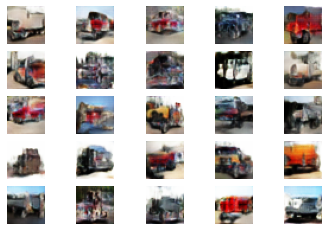

>136, 1/39, d1=0.216, d2=0.361 g=2.210
>136, 2/39, d1=0.590, d2=0.304 g=1.814
>136, 3/39, d1=0.242, d2=0.694 g=2.207
>136, 4/39, d1=0.617, d2=0.300 g=2.004
>136, 5/39, d1=0.469, d2=0.399 g=1.788
>136, 6/39, d1=0.285, d2=0.531 g=2.117
>136, 7/39, d1=0.590, d2=0.395 g=2.271
>136, 8/39, d1=0.449, d2=0.345 g=2.343
>136, 9/39, d1=0.485, d2=0.292 g=2.136
>136, 10/39, d1=0.401, d2=0.327 g=2.035
>136, 11/39, d1=0.236, d2=0.552 g=2.467
>136, 12/39, d1=0.526, d2=0.358 g=2.222
>136, 13/39, d1=0.507, d2=0.371 g=2.085
>136, 14/39, d1=0.373, d2=0.367 g=2.115
>136, 15/39, d1=0.385, d2=0.345 g=2.076
>136, 16/39, d1=0.419, d2=0.429 g=2.053
>136, 17/39, d1=0.474, d2=0.398 g=2.117
>136, 18/39, d1=0.497, d2=0.409 g=2.102
>136, 19/39, d1=0.415, d2=0.363 g=2.176
>136, 20/39, d1=0.358, d2=0.365 g=2.179
>136, 21/39, d1=0.428, d2=0.307 g=1.996
>136, 22/39, d1=0.425, d2=0.694 g=2.320
>136, 23/39, d1=0.570, d2=0.325 g=2.174
>136, 24/39, d1=0.572, d2=0.258 g=1.854
>136, 25/39, d1=0.375, d2=0.502 g=1.857
>136, 26/

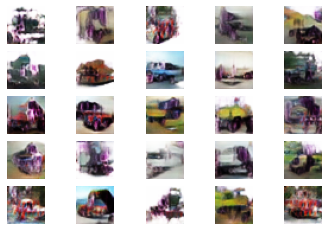

>141, 1/39, d1=0.228, d2=0.331 g=1.996
>141, 2/39, d1=0.344, d2=0.472 g=2.434
>141, 3/39, d1=0.415, d2=0.484 g=2.482
>141, 4/39, d1=0.332, d2=0.277 g=2.456
>141, 5/39, d1=0.475, d2=0.350 g=2.241
>141, 6/39, d1=0.508, d2=0.361 g=2.135
>141, 7/39, d1=0.411, d2=0.610 g=2.312
>141, 8/39, d1=0.374, d2=0.278 g=2.405
>141, 9/39, d1=0.540, d2=0.369 g=2.285
>141, 10/39, d1=0.455, d2=0.347 g=1.972
>141, 11/39, d1=0.254, d2=0.516 g=2.275
>141, 12/39, d1=0.450, d2=0.291 g=2.132
>141, 13/39, d1=0.460, d2=0.429 g=2.271
>141, 14/39, d1=0.516, d2=0.560 g=2.222
>141, 15/39, d1=0.634, d2=0.454 g=1.827
>141, 16/39, d1=0.315, d2=0.488 g=2.072
>141, 17/39, d1=0.434, d2=0.309 g=2.148
>141, 18/39, d1=0.412, d2=0.226 g=1.837
>141, 19/39, d1=0.355, d2=0.703 g=2.408
>141, 20/39, d1=0.572, d2=0.268 g=2.057
>141, 21/39, d1=0.524, d2=0.616 g=2.078
>141, 22/39, d1=0.489, d2=0.282 g=2.103
>141, 23/39, d1=0.371, d2=0.502 g=2.193
>141, 24/39, d1=0.547, d2=0.423 g=2.237
>141, 25/39, d1=0.417, d2=0.273 g=1.986
>141, 26/

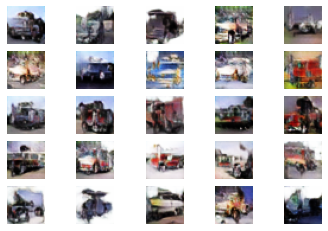

>146, 1/39, d1=0.205, d2=0.428 g=2.519
>146, 2/39, d1=0.596, d2=0.442 g=2.208
>146, 3/39, d1=0.426, d2=0.273 g=2.272
>146, 4/39, d1=0.375, d2=0.381 g=1.981
>146, 5/39, d1=0.325, d2=0.410 g=2.138
>146, 6/39, d1=0.301, d2=0.414 g=2.072
>146, 7/39, d1=0.522, d2=0.371 g=2.056
>146, 8/39, d1=0.362, d2=0.477 g=2.189
>146, 9/39, d1=0.606, d2=0.387 g=1.815
>146, 10/39, d1=0.310, d2=0.404 g=2.231
>146, 11/39, d1=0.507, d2=0.405 g=2.148
>146, 12/39, d1=0.314, d2=0.345 g=2.249
>146, 13/39, d1=0.476, d2=0.425 g=2.439
>146, 14/39, d1=0.441, d2=0.312 g=2.226
>146, 15/39, d1=0.427, d2=0.488 g=2.389
>146, 16/39, d1=0.643, d2=0.367 g=2.315
>146, 17/39, d1=0.349, d2=0.358 g=2.297
>146, 18/39, d1=0.444, d2=0.349 g=2.437
>146, 19/39, d1=0.472, d2=0.380 g=2.119
>146, 20/39, d1=0.446, d2=0.535 g=2.285
>146, 21/39, d1=0.421, d2=0.210 g=2.068
>146, 22/39, d1=0.464, d2=0.522 g=2.082
>146, 23/39, d1=0.340, d2=0.433 g=2.224
>146, 24/39, d1=0.416, d2=0.348 g=2.103
>146, 25/39, d1=0.298, d2=0.428 g=2.395
>146, 26/

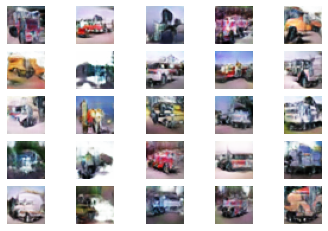

>151, 1/39, d1=0.190, d2=0.268 g=2.299
>151, 2/39, d1=0.393, d2=0.511 g=2.419
>151, 3/39, d1=0.552, d2=0.385 g=2.128
>151, 4/39, d1=0.490, d2=0.458 g=2.221
>151, 5/39, d1=0.541, d2=0.313 g=1.959
>151, 6/39, d1=0.431, d2=0.631 g=2.135
>151, 7/39, d1=0.557, d2=0.324 g=2.030
>151, 8/39, d1=0.314, d2=0.373 g=1.951
>151, 9/39, d1=0.404, d2=0.461 g=2.114
>151, 10/39, d1=0.435, d2=0.387 g=1.995
>151, 11/39, d1=0.440, d2=0.584 g=2.250
>151, 12/39, d1=0.566, d2=0.370 g=2.141
>151, 13/39, d1=0.493, d2=0.363 g=1.996
>151, 14/39, d1=0.393, d2=0.336 g=2.014
>151, 15/39, d1=0.503, d2=0.410 g=1.936
>151, 16/39, d1=0.315, d2=0.463 g=2.103
>151, 17/39, d1=0.295, d2=0.355 g=2.207
>151, 18/39, d1=0.470, d2=0.357 g=2.250
>151, 19/39, d1=0.468, d2=0.449 g=2.217
>151, 20/39, d1=0.511, d2=0.283 g=2.172
>151, 21/39, d1=0.390, d2=0.422 g=2.016
>151, 22/39, d1=0.321, d2=0.260 g=2.398
>151, 23/39, d1=0.376, d2=0.376 g=2.228
>151, 24/39, d1=0.452, d2=0.332 g=2.323
>151, 25/39, d1=0.427, d2=0.486 g=1.987
>151, 26/

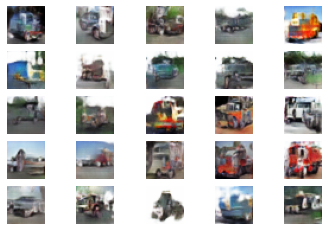

>156, 1/39, d1=0.222, d2=0.486 g=2.116
>156, 2/39, d1=0.434, d2=0.368 g=2.038
>156, 3/39, d1=0.365, d2=0.339 g=2.171
>156, 4/39, d1=0.330, d2=0.425 g=2.332
>156, 5/39, d1=0.400, d2=0.273 g=2.136
>156, 6/39, d1=0.365, d2=0.478 g=2.227
>156, 7/39, d1=0.325, d2=0.422 g=2.664
>156, 8/39, d1=0.507, d2=0.246 g=2.177
>156, 9/39, d1=0.283, d2=0.680 g=2.573
>156, 10/39, d1=0.427, d2=0.191 g=2.261
>156, 11/39, d1=0.439, d2=0.414 g=2.394
>156, 12/39, d1=0.510, d2=0.394 g=2.008
>156, 13/39, d1=0.352, d2=0.491 g=2.367
>156, 14/39, d1=0.493, d2=0.246 g=2.080
>156, 15/39, d1=0.390, d2=0.456 g=2.268
>156, 16/39, d1=0.569, d2=0.385 g=2.096
>156, 17/39, d1=0.260, d2=0.388 g=2.200
>156, 18/39, d1=0.416, d2=0.310 g=2.202
>156, 19/39, d1=0.260, d2=0.267 g=2.279
>156, 20/39, d1=0.268, d2=0.438 g=2.290
>156, 21/39, d1=0.325, d2=0.432 g=2.499
>156, 22/39, d1=0.390, d2=0.251 g=2.522
>156, 23/39, d1=0.430, d2=0.525 g=2.607
>156, 24/39, d1=0.471, d2=0.274 g=2.148
>156, 25/39, d1=0.459, d2=0.622 g=2.139
>156, 26/

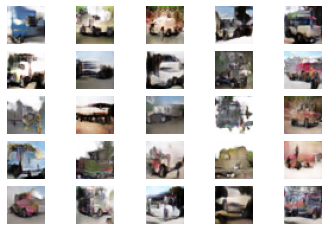

>161, 1/39, d1=0.212, d2=0.276 g=2.419
>161, 2/39, d1=0.389, d2=0.522 g=2.474
>161, 3/39, d1=0.435, d2=0.406 g=2.297
>161, 4/39, d1=0.516, d2=0.314 g=2.022
>161, 5/39, d1=0.244, d2=0.422 g=2.190
>161, 6/39, d1=0.305, d2=0.346 g=2.217
>161, 7/39, d1=0.312, d2=0.390 g=2.541
>161, 8/39, d1=0.332, d2=0.373 g=2.804
>161, 9/39, d1=0.533, d2=0.302 g=2.329
>161, 10/39, d1=0.370, d2=0.543 g=2.737
>161, 11/39, d1=0.596, d2=0.225 g=2.601
>161, 12/39, d1=0.417, d2=0.451 g=2.216
>161, 13/39, d1=0.244, d2=0.384 g=2.201
>161, 14/39, d1=0.291, d2=0.406 g=2.739
>161, 15/39, d1=0.426, d2=0.208 g=2.606
>161, 16/39, d1=0.340, d2=0.407 g=2.835
>161, 17/39, d1=0.399, d2=0.250 g=2.502
>161, 18/39, d1=0.239, d2=0.351 g=2.292
>161, 19/39, d1=0.237, d2=0.298 g=2.547
>161, 20/39, d1=0.460, d2=0.413 g=2.663
>161, 21/39, d1=0.319, d2=0.208 g=2.601
>161, 22/39, d1=0.343, d2=0.441 g=2.498
>161, 23/39, d1=0.368, d2=0.223 g=2.758
>161, 24/39, d1=0.386, d2=0.279 g=2.552
>161, 25/39, d1=0.204, d2=0.297 g=2.809
>161, 26/

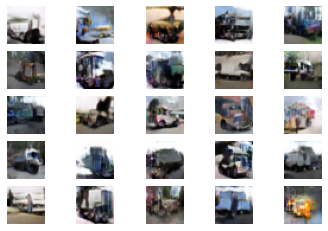

>166, 1/39, d1=0.191, d2=0.480 g=2.364
>166, 2/39, d1=0.467, d2=0.228 g=2.385
>166, 3/39, d1=0.529, d2=0.366 g=2.082
>166, 4/39, d1=0.277, d2=0.448 g=2.133
>166, 5/39, d1=0.398, d2=0.303 g=2.153
>166, 6/39, d1=0.468, d2=0.335 g=2.115
>166, 7/39, d1=0.257, d2=0.383 g=2.515
>166, 8/39, d1=0.393, d2=0.358 g=2.397
>166, 9/39, d1=0.509, d2=0.407 g=2.273
>166, 10/39, d1=0.429, d2=0.427 g=2.359
>166, 11/39, d1=0.366, d2=0.416 g=2.333
>166, 12/39, d1=0.523, d2=0.367 g=2.364
>166, 13/39, d1=0.497, d2=0.345 g=2.166
>166, 14/39, d1=0.452, d2=0.500 g=2.072
>166, 15/39, d1=0.452, d2=0.359 g=2.225
>166, 16/39, d1=0.287, d2=0.372 g=2.319
>166, 17/39, d1=0.441, d2=0.306 g=2.237
>166, 18/39, d1=0.408, d2=0.370 g=2.167
>166, 19/39, d1=0.309, d2=0.620 g=2.449
>166, 20/39, d1=0.562, d2=0.235 g=2.273
>166, 21/39, d1=0.374, d2=0.309 g=2.127
>166, 22/39, d1=0.359, d2=0.475 g=2.390
>166, 23/39, d1=0.380, d2=0.247 g=2.506
>166, 24/39, d1=0.639, d2=0.345 g=2.110
>166, 25/39, d1=0.304, d2=0.501 g=2.389
>166, 26/

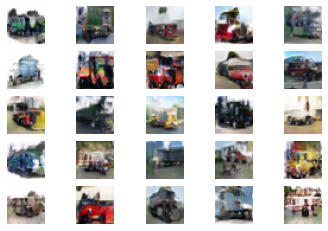

>171, 1/39, d1=0.157, d2=0.439 g=2.864
>171, 2/39, d1=0.486, d2=0.348 g=2.818
>171, 3/39, d1=0.447, d2=0.459 g=2.911
>171, 4/39, d1=0.435, d2=0.347 g=2.667
>171, 5/39, d1=0.421, d2=0.374 g=2.334
>171, 6/39, d1=0.284, d2=0.367 g=2.465
>171, 7/39, d1=0.455, d2=0.298 g=2.413
>171, 8/39, d1=0.263, d2=0.398 g=2.913
>171, 9/39, d1=0.505, d2=0.421 g=2.559
>171, 10/39, d1=0.308, d2=0.316 g=2.639
>171, 11/39, d1=0.594, d2=0.438 g=2.517
>171, 12/39, d1=0.411, d2=0.362 g=2.374
>171, 13/39, d1=0.321, d2=0.398 g=2.599
>171, 14/39, d1=0.272, d2=0.241 g=2.769
>171, 15/39, d1=0.468, d2=0.281 g=2.480
>171, 16/39, d1=0.387, d2=0.483 g=2.598
>171, 17/39, d1=0.414, d2=0.202 g=2.436
>171, 18/39, d1=0.275, d2=0.322 g=2.309
>171, 19/39, d1=0.385, d2=0.293 g=2.358
>171, 20/39, d1=0.300, d2=0.341 g=2.470
>171, 21/39, d1=0.475, d2=0.461 g=2.511
>171, 22/39, d1=0.363, d2=0.277 g=2.444
>171, 23/39, d1=0.370, d2=0.392 g=2.429
>171, 24/39, d1=0.376, d2=0.415 g=2.550
>171, 25/39, d1=0.308, d2=0.386 g=2.586
>171, 26/

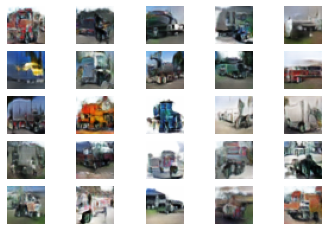

>176, 1/39, d1=0.164, d2=0.422 g=2.568
>176, 2/39, d1=0.376, d2=0.268 g=2.513
>176, 3/39, d1=0.328, d2=0.239 g=2.174
>176, 4/39, d1=0.434, d2=0.524 g=2.305
>176, 5/39, d1=0.388, d2=0.401 g=2.615
>176, 6/39, d1=0.506, d2=0.299 g=2.273
>176, 7/39, d1=0.300, d2=0.655 g=2.582
>176, 8/39, d1=0.475, d2=0.220 g=2.639
>176, 9/39, d1=0.361, d2=0.427 g=2.580
>176, 10/39, d1=0.365, d2=0.254 g=2.554
>176, 11/39, d1=0.621, d2=0.479 g=2.193
>176, 12/39, d1=0.248, d2=0.354 g=2.584
>176, 13/39, d1=0.443, d2=0.271 g=2.597
>176, 14/39, d1=0.488, d2=0.563 g=2.462
>176, 15/39, d1=0.445, d2=0.292 g=2.444
>176, 16/39, d1=0.361, d2=0.304 g=2.185
>176, 17/39, d1=0.465, d2=0.478 g=2.317
>176, 18/39, d1=0.319, d2=0.382 g=2.521
>176, 19/39, d1=0.286, d2=0.188 g=2.455
>176, 20/39, d1=0.354, d2=0.424 g=2.377
>176, 21/39, d1=0.396, d2=0.390 g=2.712
>176, 22/39, d1=0.325, d2=0.317 g=2.509
>176, 23/39, d1=0.471, d2=0.484 g=2.390
>176, 24/39, d1=0.278, d2=0.238 g=2.357
>176, 25/39, d1=0.346, d2=0.430 g=2.413
>176, 26/

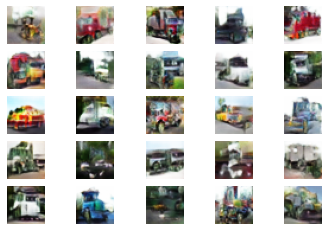

>181, 1/39, d1=0.158, d2=0.379 g=2.716
>181, 2/39, d1=0.495, d2=0.492 g=2.717
>181, 3/39, d1=0.548, d2=0.314 g=2.352
>181, 4/39, d1=0.177, d2=0.214 g=2.482
>181, 5/39, d1=0.324, d2=0.476 g=2.429
>181, 6/39, d1=0.384, d2=0.344 g=2.536
>181, 7/39, d1=0.380, d2=0.408 g=2.757
>181, 8/39, d1=0.427, d2=0.389 g=2.668
>181, 9/39, d1=0.443, d2=0.305 g=2.532
>181, 10/39, d1=0.474, d2=0.374 g=2.343
>181, 11/39, d1=0.162, d2=0.299 g=2.586
>181, 12/39, d1=0.456, d2=0.410 g=2.285
>181, 13/39, d1=0.275, d2=0.384 g=2.810
>181, 14/39, d1=0.381, d2=0.229 g=2.565
>181, 15/39, d1=0.425, d2=0.328 g=2.574
>181, 16/39, d1=0.265, d2=0.337 g=2.936
>181, 17/39, d1=0.296, d2=0.230 g=2.735
>181, 18/39, d1=0.392, d2=0.381 g=2.699
>181, 19/39, d1=0.330, d2=0.319 g=2.483
>181, 20/39, d1=0.299, d2=0.486 g=3.004
>181, 21/39, d1=0.341, d2=0.193 g=2.570
>181, 22/39, d1=0.361, d2=0.220 g=2.398
>181, 23/39, d1=0.123, d2=0.411 g=3.100
>181, 24/39, d1=0.450, d2=0.179 g=2.903
>181, 25/39, d1=0.335, d2=0.325 g=2.660
>181, 26/

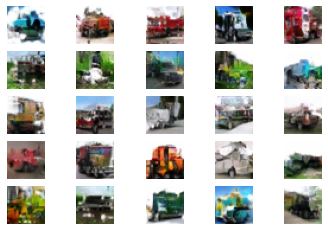

>186, 1/39, d1=0.151, d2=0.273 g=2.762
>186, 2/39, d1=0.342, d2=0.453 g=2.968
>186, 3/39, d1=0.359, d2=0.189 g=2.757
>186, 4/39, d1=0.317, d2=0.525 g=3.128
>186, 5/39, d1=0.625, d2=0.253 g=2.449
>186, 6/39, d1=0.370, d2=0.552 g=2.443
>186, 7/39, d1=0.463, d2=0.442 g=2.648
>186, 8/39, d1=0.343, d2=0.193 g=2.199
>186, 9/39, d1=0.333, d2=0.555 g=2.526
>186, 10/39, d1=0.301, d2=0.339 g=2.723
>186, 11/39, d1=0.505, d2=0.234 g=2.411
>186, 12/39, d1=0.378, d2=0.256 g=2.326
>186, 13/39, d1=0.260, d2=0.658 g=2.825
>186, 14/39, d1=0.336, d2=0.194 g=2.764
>186, 15/39, d1=0.500, d2=0.609 g=2.999
>186, 16/39, d1=0.344, d2=0.167 g=2.499
>186, 17/39, d1=0.547, d2=0.619 g=2.345
>186, 18/39, d1=0.277, d2=0.238 g=2.865
>186, 19/39, d1=0.556, d2=0.260 g=2.404
>186, 20/39, d1=0.268, d2=0.474 g=2.813
>186, 21/39, d1=0.387, d2=0.251 g=2.810
>186, 22/39, d1=0.482, d2=0.301 g=2.477
>186, 23/39, d1=0.318, d2=0.336 g=2.353
>186, 24/39, d1=0.302, d2=0.312 g=2.608
>186, 25/39, d1=0.342, d2=0.368 g=2.864
>186, 26/

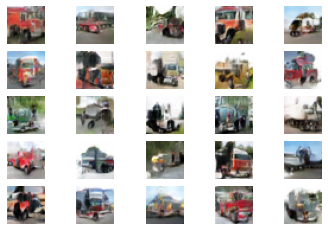

>191, 1/39, d1=0.143, d2=0.133 g=2.551
>191, 2/39, d1=0.361, d2=0.392 g=2.368
>191, 3/39, d1=0.207, d2=0.375 g=2.629
>191, 4/39, d1=0.378, d2=0.314 g=2.711
>191, 5/39, d1=0.404, d2=0.333 g=2.538
>191, 6/39, d1=0.356, d2=0.539 g=2.759
>191, 7/39, d1=0.378, d2=0.286 g=2.809
>191, 8/39, d1=0.298, d2=0.376 g=2.953
>191, 9/39, d1=0.525, d2=0.388 g=2.799
>191, 10/39, d1=0.397, d2=0.279 g=2.808
>191, 11/39, d1=0.356, d2=0.281 g=2.683
>191, 12/39, d1=0.365, d2=0.406 g=2.925
>191, 13/39, d1=0.513, d2=0.359 g=2.661
>191, 14/39, d1=0.375, d2=0.451 g=2.712
>191, 15/39, d1=0.235, d2=0.318 g=3.195
>191, 16/39, d1=0.446, d2=0.233 g=2.446
>191, 17/39, d1=0.342, d2=0.420 g=2.456
>191, 18/39, d1=0.261, d2=0.269 g=2.911
>191, 19/39, d1=0.292, d2=0.315 g=2.929
>191, 20/39, d1=0.425, d2=0.359 g=2.341
>191, 21/39, d1=0.257, d2=0.491 g=3.022
>191, 22/39, d1=0.387, d2=0.232 g=2.966
>191, 23/39, d1=0.396, d2=0.357 g=2.703
>191, 24/39, d1=0.364, d2=0.354 g=2.423
>191, 25/39, d1=0.404, d2=0.393 g=2.645
>191, 26/

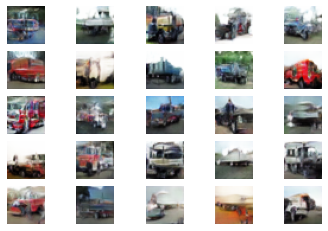

>196, 1/39, d1=0.174, d2=0.335 g=2.682
>196, 2/39, d1=0.338, d2=0.567 g=3.162
>196, 3/39, d1=0.361, d2=0.224 g=2.827
>196, 4/39, d1=0.552, d2=0.372 g=2.440
>196, 5/39, d1=0.198, d2=0.339 g=3.077
>196, 6/39, d1=0.391, d2=0.281 g=2.903
>196, 7/39, d1=0.354, d2=0.399 g=2.841
>196, 8/39, d1=0.362, d2=0.202 g=2.826
>196, 9/39, d1=0.414, d2=0.356 g=2.755
>196, 10/39, d1=0.393, d2=0.330 g=2.826
>196, 11/39, d1=0.305, d2=0.428 g=2.921
>196, 12/39, d1=0.365, d2=0.249 g=2.808
>196, 13/39, d1=0.313, d2=0.418 g=3.145
>196, 14/39, d1=0.509, d2=0.196 g=2.518
>196, 15/39, d1=0.138, d2=0.419 g=3.007
>196, 16/39, d1=0.378, d2=0.277 g=2.749
>196, 17/39, d1=0.408, d2=0.274 g=2.854
>196, 18/39, d1=0.206, d2=0.262 g=3.082
>196, 19/39, d1=0.287, d2=0.340 g=3.137
>196, 20/39, d1=0.422, d2=0.398 g=2.962
>196, 21/39, d1=0.433, d2=0.310 g=2.862
>196, 22/39, d1=0.298, d2=0.437 g=2.943
>196, 23/39, d1=0.276, d2=0.175 g=2.994
>196, 24/39, d1=0.289, d2=0.275 g=2.943
>196, 25/39, d1=0.457, d2=0.215 g=2.288
>196, 26/

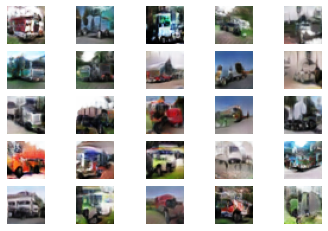

>201, 1/39, d1=0.144, d2=0.266 g=2.838
>201, 2/39, d1=0.200, d2=0.219 g=2.918
>201, 3/39, d1=0.271, d2=0.363 g=2.850
>201, 4/39, d1=0.412, d2=0.266 g=2.690
>201, 5/39, d1=0.195, d2=0.314 g=2.900
>201, 6/39, d1=0.374, d2=0.364 g=2.902
>201, 7/39, d1=0.445, d2=0.335 g=2.804
>201, 8/39, d1=0.368, d2=0.406 g=2.555
>201, 9/39, d1=0.459, d2=0.341 g=2.618
>201, 10/39, d1=0.254, d2=0.365 g=3.011
>201, 11/39, d1=0.355, d2=0.223 g=2.786
>201, 12/39, d1=0.265, d2=0.340 g=2.853
>201, 13/39, d1=0.237, d2=0.312 g=3.353
>201, 14/39, d1=0.471, d2=0.230 g=2.723
>201, 15/39, d1=0.286, d2=0.428 g=3.008
>201, 16/39, d1=0.363, d2=0.351 g=3.153
>201, 17/39, d1=0.506, d2=0.387 g=2.829
>201, 18/39, d1=0.222, d2=0.306 g=2.988
>201, 19/39, d1=0.383, d2=0.361 g=2.987
>201, 20/39, d1=0.342, d2=0.262 g=2.684
>201, 21/39, d1=0.223, d2=0.469 g=3.164
>201, 22/39, d1=0.452, d2=0.252 g=3.031
>201, 23/39, d1=0.360, d2=0.316 g=2.580
>201, 24/39, d1=0.213, d2=0.318 g=3.135
>201, 25/39, d1=0.389, d2=0.368 g=3.123
>201, 26/

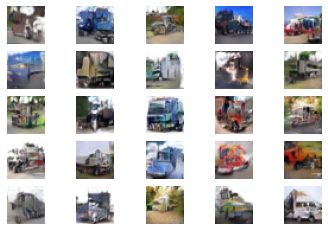

>206, 1/39, d1=0.140, d2=0.229 g=3.193
>206, 2/39, d1=0.267, d2=0.225 g=3.056
>206, 3/39, d1=0.318, d2=0.264 g=2.621
>206, 4/39, d1=0.194, d2=0.226 g=3.127
>206, 5/39, d1=0.341, d2=0.235 g=2.949
>206, 6/39, d1=0.211, d2=0.291 g=3.185
>206, 7/39, d1=0.389, d2=0.418 g=3.238
>206, 8/39, d1=0.306, d2=0.269 g=3.048
>206, 9/39, d1=0.425, d2=0.415 g=2.823
>206, 10/39, d1=0.351, d2=0.447 g=3.086
>206, 11/39, d1=0.221, d2=0.422 g=3.398
>206, 12/39, d1=0.455, d2=0.284 g=2.955
>206, 13/39, d1=0.431, d2=0.328 g=2.649
>206, 14/39, d1=0.233, d2=0.340 g=3.283
>206, 15/39, d1=0.466, d2=0.368 g=3.203
>206, 16/39, d1=0.408, d2=0.319 g=2.585
>206, 17/39, d1=0.261, d2=0.484 g=3.084
>206, 18/39, d1=0.171, d2=0.267 g=3.291
>206, 19/39, d1=0.615, d2=0.370 g=2.921
>206, 20/39, d1=0.335, d2=0.311 g=2.894
>206, 21/39, d1=0.275, d2=0.276 g=3.023
>206, 22/39, d1=0.275, d2=0.370 g=3.103
>206, 23/39, d1=0.318, d2=0.170 g=2.923
>206, 24/39, d1=0.211, d2=0.305 g=3.087
>206, 25/39, d1=0.405, d2=0.403 g=2.957
>206, 26/

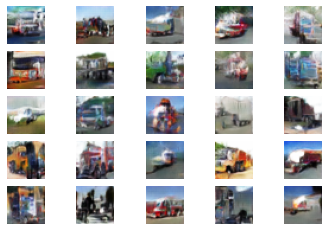

>211, 1/39, d1=0.128, d2=0.296 g=3.290
>211, 2/39, d1=0.179, d2=0.197 g=3.227
>211, 3/39, d1=0.416, d2=0.195 g=2.797
>211, 4/39, d1=0.352, d2=0.549 g=3.055
>211, 5/39, d1=0.367, d2=0.211 g=3.299
>211, 6/39, d1=0.408, d2=0.286 g=2.558
>211, 7/39, d1=0.339, d2=0.392 g=2.551
>211, 8/39, d1=0.150, d2=0.333 g=2.998
>211, 9/39, d1=0.405, d2=0.232 g=3.118
>211, 10/39, d1=0.396, d2=0.383 g=2.926
>211, 11/39, d1=0.223, d2=0.219 g=3.055
>211, 12/39, d1=0.242, d2=0.243 g=3.232
>211, 13/39, d1=0.328, d2=0.409 g=3.400
>211, 14/39, d1=0.351, d2=0.237 g=3.398
>211, 15/39, d1=0.402, d2=0.447 g=2.833
>211, 16/39, d1=0.332, d2=0.338 g=2.996
>211, 17/39, d1=0.373, d2=0.616 g=3.389
>211, 18/39, d1=0.322, d2=0.223 g=3.200
>211, 19/39, d1=0.385, d2=0.290 g=3.360
>211, 20/39, d1=0.408, d2=0.229 g=3.020
>211, 21/39, d1=0.254, d2=0.515 g=3.457
>211, 22/39, d1=0.380, d2=0.238 g=3.243
>211, 23/39, d1=0.350, d2=0.313 g=2.857
>211, 24/39, d1=0.186, d2=0.296 g=3.146
>211, 25/39, d1=0.250, d2=0.360 g=3.437
>211, 26/

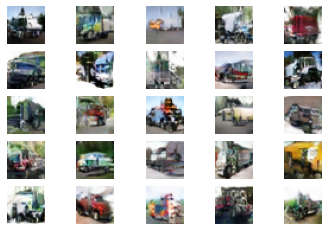

>216, 1/39, d1=0.163, d2=0.342 g=3.021
>216, 2/39, d1=0.319, d2=0.280 g=2.944
>216, 3/39, d1=0.239, d2=0.312 g=3.099
>216, 4/39, d1=0.344, d2=0.459 g=3.607
>216, 5/39, d1=0.291, d2=0.289 g=3.688
>216, 6/39, d1=0.414, d2=0.504 g=3.868
>216, 7/39, d1=0.466, d2=0.348 g=3.306
>216, 8/39, d1=0.369, d2=0.312 g=3.353
>216, 9/39, d1=0.300, d2=0.339 g=3.340
>216, 10/39, d1=0.387, d2=0.324 g=2.847
>216, 11/39, d1=0.259, d2=0.305 g=3.165
>216, 12/39, d1=0.252, d2=0.345 g=3.565
>216, 13/39, d1=0.310, d2=0.182 g=3.007
>216, 14/39, d1=0.229, d2=0.366 g=3.511
>216, 15/39, d1=0.403, d2=0.396 g=3.192
>216, 16/39, d1=0.319, d2=0.305 g=3.137
>216, 17/39, d1=0.326, d2=0.408 g=3.470
>216, 18/39, d1=0.324, d2=0.379 g=3.129
>216, 19/39, d1=0.279, d2=0.308 g=3.466
>216, 20/39, d1=0.405, d2=0.244 g=3.176
>216, 21/39, d1=0.283, d2=0.271 g=2.990
>216, 22/39, d1=0.242, d2=0.365 g=3.650
>216, 23/39, d1=0.294, d2=0.233 g=3.580
>216, 24/39, d1=0.242, d2=0.351 g=3.735
>216, 25/39, d1=0.378, d2=0.246 g=3.246
>216, 26/

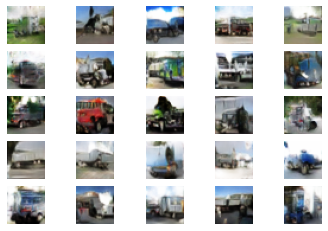

>221, 1/39, d1=0.117, d2=0.214 g=3.414
>221, 2/39, d1=0.365, d2=0.419 g=3.173
>221, 3/39, d1=0.249, d2=0.162 g=3.596
>221, 4/39, d1=0.299, d2=0.251 g=2.884
>221, 5/39, d1=0.288, d2=0.344 g=3.107
>221, 6/39, d1=0.323, d2=0.294 g=2.991
>221, 7/39, d1=0.183, d2=0.265 g=3.372
>221, 8/39, d1=0.366, d2=0.387 g=3.578
>221, 9/39, d1=0.468, d2=0.219 g=3.141
>221, 10/39, d1=0.209, d2=0.284 g=3.070
>221, 11/39, d1=0.236, d2=0.321 g=3.231
>221, 12/39, d1=0.323, d2=0.251 g=3.805
>221, 13/39, d1=0.364, d2=0.354 g=3.273
>221, 14/39, d1=0.368, d2=0.664 g=3.737
>221, 15/39, d1=0.424, d2=0.290 g=3.035
>221, 16/39, d1=0.409, d2=0.358 g=3.316
>221, 17/39, d1=0.237, d2=0.215 g=3.284
>221, 18/39, d1=0.338, d2=0.386 g=3.602
>221, 19/39, d1=0.343, d2=0.315 g=3.754
>221, 20/39, d1=0.366, d2=0.205 g=3.120
>221, 21/39, d1=0.256, d2=0.495 g=3.360
>221, 22/39, d1=0.350, d2=0.306 g=3.558
>221, 23/39, d1=0.388, d2=0.224 g=3.062
>221, 24/39, d1=0.230, d2=0.477 g=3.545
>221, 25/39, d1=0.255, d2=0.228 g=3.721
>221, 26/

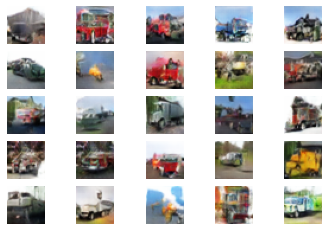

>226, 1/39, d1=0.136, d2=0.484 g=3.342
>226, 2/39, d1=0.288, d2=0.195 g=3.341
>226, 3/39, d1=0.353, d2=0.289 g=3.262
>226, 4/39, d1=0.201, d2=0.322 g=3.612
>226, 5/39, d1=0.342, d2=0.305 g=3.765
>226, 6/39, d1=0.346, d2=0.209 g=3.302
>226, 7/39, d1=0.237, d2=0.791 g=3.881
>226, 8/39, d1=0.336, d2=0.177 g=3.179
>226, 9/39, d1=0.396, d2=0.532 g=3.600
>226, 10/39, d1=0.545, d2=0.351 g=2.679
>226, 11/39, d1=0.282, d2=0.335 g=2.892
>226, 12/39, d1=0.256, d2=0.252 g=3.310
>226, 13/39, d1=0.229, d2=0.323 g=3.384
>226, 14/39, d1=0.414, d2=0.304 g=3.107
>226, 15/39, d1=0.263, d2=0.193 g=3.127
>226, 16/39, d1=0.152, d2=0.147 g=3.162
>226, 17/39, d1=0.190, d2=0.412 g=3.197
>226, 18/39, d1=0.169, d2=0.212 g=3.680
>226, 19/39, d1=0.259, d2=0.419 g=4.341
>226, 20/39, d1=0.675, d2=0.296 g=2.860
>226, 21/39, d1=0.283, d2=0.470 g=3.004
>226, 22/39, d1=0.220, d2=0.295 g=3.777
>226, 23/39, d1=0.503, d2=0.528 g=3.466
>226, 24/39, d1=0.251, d2=0.333 g=3.404
>226, 25/39, d1=0.305, d2=0.346 g=3.884
>226, 26/

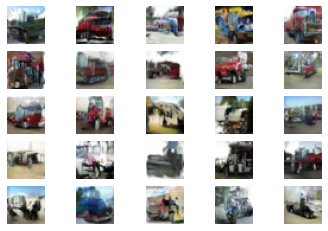

>231, 1/39, d1=0.138, d2=0.444 g=2.989
>231, 2/39, d1=0.284, d2=0.236 g=3.910
>231, 3/39, d1=0.300, d2=0.281 g=3.340
>231, 4/39, d1=0.202, d2=0.360 g=3.814
>231, 5/39, d1=0.343, d2=0.215 g=2.939
>231, 6/39, d1=0.172, d2=0.244 g=3.344
>231, 7/39, d1=0.300, d2=0.411 g=3.461
>231, 8/39, d1=0.288, d2=0.226 g=3.714
>231, 9/39, d1=0.444, d2=0.281 g=3.077
>231, 10/39, d1=0.157, d2=0.243 g=3.181
>231, 11/39, d1=0.327, d2=0.247 g=3.098
>231, 12/39, d1=0.183, d2=0.419 g=3.998
>231, 13/39, d1=0.299, d2=0.178 g=3.385
>231, 14/39, d1=0.227, d2=0.354 g=3.894
>231, 15/39, d1=0.393, d2=0.464 g=3.261
>231, 16/39, d1=0.339, d2=0.295 g=3.302
>231, 17/39, d1=0.231, d2=0.247 g=3.417
>231, 18/39, d1=0.201, d2=0.274 g=3.646
>231, 19/39, d1=0.445, d2=0.322 g=3.200
>231, 20/39, d1=0.284, d2=0.240 g=3.621
>231, 21/39, d1=0.398, d2=0.251 g=3.124
>231, 22/39, d1=0.163, d2=0.344 g=3.789
>231, 23/39, d1=0.276, d2=0.227 g=3.369
>231, 24/39, d1=0.355, d2=0.241 g=2.871
>231, 25/39, d1=0.254, d2=0.310 g=2.972
>231, 26/

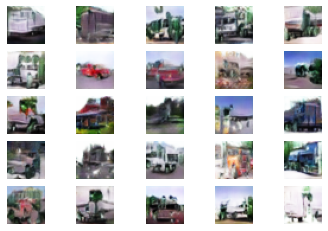

>236, 1/39, d1=0.121, d2=0.399 g=4.069
>236, 2/39, d1=0.513, d2=0.284 g=3.541
>236, 3/39, d1=0.226, d2=0.351 g=3.472
>236, 4/39, d1=0.241, d2=0.188 g=3.319
>236, 5/39, d1=0.180, d2=0.185 g=3.584
>236, 6/39, d1=0.147, d2=0.266 g=4.384
>236, 7/39, d1=0.292, d2=0.169 g=3.955
>236, 8/39, d1=0.265, d2=0.257 g=3.686
>236, 9/39, d1=0.162, d2=0.334 g=3.697
>236, 10/39, d1=0.331, d2=0.246 g=4.006
>236, 11/39, d1=0.307, d2=0.189 g=3.474
>236, 12/39, d1=0.205, d2=0.297 g=3.771
>236, 13/39, d1=0.187, d2=0.226 g=3.536
>236, 14/39, d1=0.438, d2=0.436 g=3.736
>236, 15/39, d1=0.281, d2=0.169 g=3.194
>236, 16/39, d1=0.265, d2=0.456 g=3.689
>236, 17/39, d1=0.300, d2=0.339 g=3.699
>236, 18/39, d1=0.428, d2=0.536 g=3.692
>236, 19/39, d1=0.268, d2=0.178 g=3.792
>236, 20/39, d1=0.480, d2=0.230 g=3.021
>236, 21/39, d1=0.310, d2=0.465 g=3.241
>236, 22/39, d1=0.155, d2=0.186 g=3.310
>236, 23/39, d1=0.210, d2=0.192 g=3.593
>236, 24/39, d1=0.221, d2=0.345 g=3.485
>236, 25/39, d1=0.321, d2=0.490 g=4.447
>236, 26/

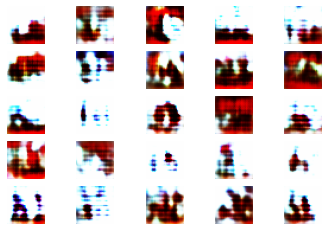

>241, 1/39, d1=0.068, d2=0.131 g=5.773
>241, 2/39, d1=0.111, d2=0.177 g=5.761
>241, 3/39, d1=0.224, d2=0.147 g=5.424
>241, 4/39, d1=0.044, d2=0.116 g=5.895
>241, 5/39, d1=0.311, d2=0.236 g=6.514
>241, 6/39, d1=0.402, d2=0.119 g=5.516
>241, 7/39, d1=0.478, d2=0.840 g=6.691
>241, 8/39, d1=0.544, d2=0.022 g=7.648
>241, 9/39, d1=0.237, d2=0.002 g=11.079
>241, 10/39, d1=0.059, d2=0.508 g=8.933
>241, 11/39, d1=0.357, d2=0.001 g=10.065
>241, 12/39, d1=0.359, d2=0.012 g=5.202
>241, 13/39, d1=0.046, d2=0.241 g=6.316
>241, 14/39, d1=0.111, d2=0.419 g=4.697
>241, 15/39, d1=0.234, d2=0.272 g=5.525
>241, 16/39, d1=0.541, d2=0.305 g=4.468
>241, 17/39, d1=0.422, d2=0.664 g=5.373
>241, 18/39, d1=0.361, d2=0.184 g=5.868
>241, 19/39, d1=0.322, d2=0.042 g=4.989
>241, 20/39, d1=0.142, d2=0.674 g=5.708
>241, 21/39, d1=0.496, d2=0.844 g=4.666
>241, 22/39, d1=1.406, d2=0.046 g=5.024
>241, 23/39, d1=0.168, d2=0.825 g=4.603
>241, 24/39, d1=0.668, d2=2.014 g=5.257
>241, 25/39, d1=1.790, d2=0.136 g=3.869
>241, 2

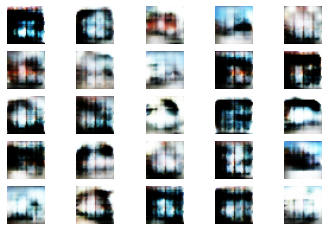

>246, 1/39, d1=0.095, d2=0.421 g=3.253
>246, 2/39, d1=0.169, d2=0.113 g=3.019
>246, 3/39, d1=0.248, d2=0.224 g=2.839
>246, 4/39, d1=0.084, d2=0.157 g=2.907
>246, 5/39, d1=0.062, d2=0.362 g=4.057
>246, 6/39, d1=0.299, d2=0.059 g=3.238
>246, 7/39, d1=0.098, d2=0.213 g=3.783
>246, 8/39, d1=0.213, d2=0.219 g=4.292
>246, 9/39, d1=0.197, d2=0.084 g=3.812
>246, 10/39, d1=0.257, d2=0.365 g=3.837
>246, 11/39, d1=0.234, d2=0.305 g=3.763
>246, 12/39, d1=0.122, d2=0.291 g=4.045
>246, 13/39, d1=0.322, d2=0.323 g=3.697
>246, 14/39, d1=0.225, d2=0.169 g=3.288
>246, 15/39, d1=0.148, d2=0.316 g=3.335
>246, 16/39, d1=0.249, d2=0.282 g=3.755
>246, 17/39, d1=0.213, d2=0.153 g=3.885
>246, 18/39, d1=0.226, d2=0.441 g=4.269
>246, 19/39, d1=0.321, d2=0.109 g=4.250
>246, 20/39, d1=0.281, d2=0.261 g=3.736
>246, 21/39, d1=0.119, d2=0.120 g=4.705
>246, 22/39, d1=0.169, d2=0.146 g=3.875
>246, 23/39, d1=0.074, d2=0.439 g=5.027
>246, 24/39, d1=0.272, d2=0.205 g=4.679
>246, 25/39, d1=0.521, d2=0.682 g=6.707
>246, 26/

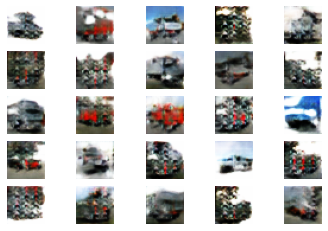

>251, 1/39, d1=0.222, d2=0.613 g=2.472
>251, 2/39, d1=0.488, d2=0.339 g=2.885
>251, 3/39, d1=0.581, d2=0.441 g=2.272
>251, 4/39, d1=0.499, d2=0.474 g=2.444
>251, 5/39, d1=0.315, d2=0.279 g=2.238
>251, 6/39, d1=0.612, d2=0.601 g=2.330
>251, 7/39, d1=0.674, d2=0.530 g=2.478
>251, 8/39, d1=0.499, d2=0.345 g=2.322
>251, 9/39, d1=0.523, d2=0.553 g=2.408
>251, 10/39, d1=0.567, d2=0.628 g=2.911
>251, 11/39, d1=0.916, d2=0.146 g=2.903
>251, 12/39, d1=0.670, d2=0.242 g=2.225
>251, 13/39, d1=0.293, d2=0.694 g=2.063
>251, 14/39, d1=0.410, d2=0.662 g=2.174
>251, 15/39, d1=0.486, d2=0.326 g=2.348
>251, 16/39, d1=0.674, d2=0.334 g=2.102
>251, 17/39, d1=0.258, d2=0.313 g=2.236
>251, 18/39, d1=0.264, d2=0.337 g=2.990
>251, 19/39, d1=0.378, d2=0.413 g=2.940
>251, 20/39, d1=0.299, d2=0.545 g=2.262
>251, 21/39, d1=0.573, d2=0.766 g=2.413
>251, 22/39, d1=0.592, d2=0.351 g=2.367
>251, 23/39, d1=0.642, d2=0.258 g=2.005
>251, 24/39, d1=0.370, d2=0.338 g=2.054
>251, 25/39, d1=0.264, d2=0.248 g=2.121
>251, 26/

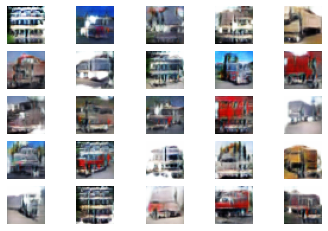

>256, 1/39, d1=0.196, d2=0.313 g=2.083
>256, 2/39, d1=0.384, d2=0.417 g=2.125
>256, 3/39, d1=0.360, d2=0.473 g=2.072
>256, 4/39, d1=0.351, d2=0.334 g=2.304
>256, 5/39, d1=0.404, d2=0.445 g=2.221
>256, 6/39, d1=0.392, d2=0.319 g=2.347
>256, 7/39, d1=0.426, d2=0.330 g=2.373
>256, 8/39, d1=0.333, d2=0.431 g=2.349
>256, 9/39, d1=0.434, d2=0.361 g=2.315
>256, 10/39, d1=0.386, d2=0.338 g=2.096
>256, 11/39, d1=0.446, d2=0.546 g=2.338
>256, 12/39, d1=0.428, d2=0.329 g=2.651
>256, 13/39, d1=0.356, d2=0.354 g=2.700
>256, 14/39, d1=0.367, d2=0.307 g=2.382
>256, 15/39, d1=0.432, d2=0.493 g=2.153
>256, 16/39, d1=0.363, d2=0.465 g=2.569
>256, 17/39, d1=0.456, d2=0.279 g=2.206
>256, 18/39, d1=0.308, d2=0.383 g=2.317
>256, 19/39, d1=0.501, d2=0.277 g=2.113
>256, 20/39, d1=0.264, d2=0.430 g=2.224
>256, 21/39, d1=0.376, d2=0.377 g=2.401
>256, 22/39, d1=0.362, d2=0.271 g=2.265
>256, 23/39, d1=0.397, d2=0.534 g=2.386
>256, 24/39, d1=0.310, d2=0.330 g=2.569
>256, 25/39, d1=0.623, d2=0.454 g=2.234
>256, 26/

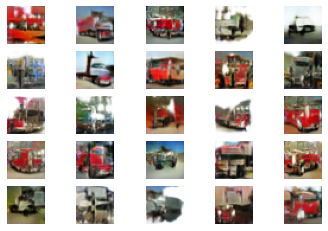

>261, 1/39, d1=0.167, d2=0.334 g=2.487
>261, 2/39, d1=0.477, d2=0.416 g=2.661
>261, 3/39, d1=0.436, d2=0.333 g=2.607
>261, 4/39, d1=0.420, d2=0.386 g=2.741
>261, 5/39, d1=0.360, d2=0.688 g=3.017
>261, 6/39, d1=0.667, d2=0.297 g=2.661
>261, 7/39, d1=0.412, d2=0.348 g=2.827
>261, 8/39, d1=0.398, d2=0.331 g=2.748
>261, 9/39, d1=0.477, d2=0.413 g=2.494
>261, 10/39, d1=0.365, d2=0.266 g=2.419
>261, 11/39, d1=0.330, d2=0.422 g=2.471
>261, 12/39, d1=0.280, d2=0.279 g=2.581
>261, 13/39, d1=0.432, d2=0.430 g=2.256
>261, 14/39, d1=0.391, d2=0.467 g=2.694
>261, 15/39, d1=0.528, d2=0.321 g=2.664
>261, 16/39, d1=0.394, d2=0.239 g=2.225
>261, 17/39, d1=0.309, d2=0.457 g=2.587
>261, 18/39, d1=0.461, d2=0.352 g=2.598
>261, 19/39, d1=0.429, d2=0.291 g=2.313
>261, 20/39, d1=0.399, d2=0.425 g=2.185
>261, 21/39, d1=0.266, d2=0.511 g=2.546
>261, 22/39, d1=0.365, d2=0.247 g=2.472
>261, 23/39, d1=0.412, d2=0.433 g=2.408
>261, 24/39, d1=0.370, d2=0.380 g=2.541
>261, 25/39, d1=0.491, d2=0.295 g=2.905
>261, 26/

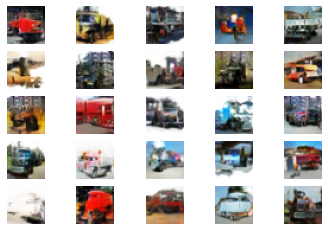

>266, 1/39, d1=0.155, d2=0.408 g=2.919
>266, 2/39, d1=0.476, d2=0.244 g=2.420
>266, 3/39, d1=0.393, d2=0.374 g=2.575
>266, 4/39, d1=0.236, d2=0.405 g=2.677
>266, 5/39, d1=0.216, d2=0.179 g=2.945
>266, 6/39, d1=0.461, d2=0.368 g=2.812
>266, 7/39, d1=0.352, d2=0.338 g=2.843
>266, 8/39, d1=0.343, d2=0.293 g=2.806
>266, 9/39, d1=0.346, d2=0.210 g=2.854
>266, 10/39, d1=0.462, d2=0.362 g=2.466
>266, 11/39, d1=0.262, d2=0.335 g=2.560
>266, 12/39, d1=0.324, d2=0.425 g=2.632
>266, 13/39, d1=0.335, d2=0.298 g=2.900
>266, 14/39, d1=0.325, d2=0.360 g=3.036
>266, 15/39, d1=0.448, d2=0.203 g=2.363
>266, 16/39, d1=0.194, d2=0.330 g=2.560
>266, 17/39, d1=0.266, d2=0.282 g=2.589
>266, 18/39, d1=0.190, d2=0.342 g=3.204
>266, 19/39, d1=0.356, d2=0.219 g=2.965
>266, 20/39, d1=0.403, d2=0.321 g=2.846
>266, 21/39, d1=0.300, d2=0.382 g=2.798
>266, 22/39, d1=0.245, d2=0.216 g=2.795
>266, 23/39, d1=0.523, d2=0.367 g=2.199
>266, 24/39, d1=0.225, d2=0.320 g=2.717
>266, 25/39, d1=0.274, d2=0.270 g=2.730
>266, 26/

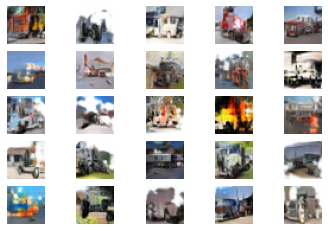

>271, 1/39, d1=0.134, d2=0.339 g=2.867
>271, 2/39, d1=0.364, d2=0.333 g=2.745
>271, 3/39, d1=0.371, d2=0.345 g=2.959
>271, 4/39, d1=0.333, d2=0.303 g=2.756
>271, 5/39, d1=0.408, d2=0.221 g=2.432
>271, 6/39, d1=0.244, d2=0.330 g=2.216
>271, 7/39, d1=0.207, d2=0.247 g=2.817
>271, 8/39, d1=0.425, d2=0.246 g=2.766
>271, 9/39, d1=0.275, d2=0.359 g=2.817
>271, 10/39, d1=0.317, d2=0.283 g=2.967
>271, 11/39, d1=0.315, d2=0.250 g=2.722
>271, 12/39, d1=0.292, d2=0.344 g=3.011
>271, 13/39, d1=0.342, d2=0.407 g=2.847
>271, 14/39, d1=0.383, d2=0.437 g=2.685
>271, 15/39, d1=0.428, d2=0.390 g=2.586
>271, 16/39, d1=0.273, d2=0.332 g=3.056
>271, 17/39, d1=0.410, d2=0.257 g=2.803
>271, 18/39, d1=0.376, d2=0.382 g=2.769
>271, 19/39, d1=0.355, d2=0.361 g=2.548
>271, 20/39, d1=0.313, d2=0.224 g=2.819
>271, 21/39, d1=0.349, d2=0.231 g=2.414
>271, 22/39, d1=0.283, d2=0.484 g=2.885
>271, 23/39, d1=0.271, d2=0.187 g=2.754
>271, 24/39, d1=0.529, d2=0.480 g=2.740
>271, 25/39, d1=0.352, d2=0.335 g=2.673
>271, 26/

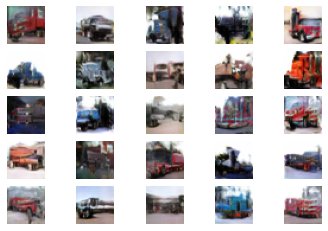

>276, 1/39, d1=0.126, d2=0.230 g=2.735
>276, 2/39, d1=0.491, d2=0.419 g=2.479
>276, 3/39, d1=0.299, d2=0.309 g=2.656
>276, 4/39, d1=0.422, d2=0.245 g=2.531
>276, 5/39, d1=0.289, d2=0.259 g=2.568
>276, 6/39, d1=0.271, d2=0.281 g=2.733
>276, 7/39, d1=0.272, d2=0.435 g=2.957
>276, 8/39, d1=0.548, d2=0.195 g=2.402
>276, 9/39, d1=0.122, d2=0.266 g=2.672
>276, 10/39, d1=0.318, d2=0.311 g=2.635
>276, 11/39, d1=0.399, d2=0.277 g=2.523
>276, 12/39, d1=0.298, d2=0.336 g=2.958
>276, 13/39, d1=0.268, d2=0.314 g=3.008
>276, 14/39, d1=0.336, d2=0.382 g=2.927
>276, 15/39, d1=0.421, d2=0.370 g=3.031
>276, 16/39, d1=0.406, d2=0.291 g=2.770
>276, 17/39, d1=0.313, d2=0.362 g=2.703
>276, 18/39, d1=0.380, d2=0.236 g=2.687
>276, 19/39, d1=0.221, d2=0.333 g=2.904
>276, 20/39, d1=0.292, d2=0.208 g=2.743
>276, 21/39, d1=0.256, d2=0.407 g=2.816
>276, 22/39, d1=0.313, d2=0.179 g=2.739
>276, 23/39, d1=0.312, d2=0.463 g=2.830
>276, 24/39, d1=0.228, d2=0.298 g=3.301
>276, 25/39, d1=0.459, d2=0.388 g=2.923
>276, 26/

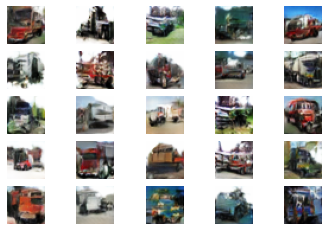

>281, 1/39, d1=0.187, d2=0.357 g=2.926
>281, 2/39, d1=0.419, d2=0.267 g=2.489
>281, 3/39, d1=0.281, d2=0.389 g=2.936
>281, 4/39, d1=0.365, d2=0.229 g=2.585
>281, 5/39, d1=0.297, d2=0.309 g=2.777
>281, 6/39, d1=0.301, d2=0.305 g=2.897
>281, 7/39, d1=0.276, d2=0.320 g=2.830
>281, 8/39, d1=0.314, d2=0.361 g=3.103
>281, 9/39, d1=0.279, d2=0.335 g=3.081
>281, 10/39, d1=0.395, d2=0.359 g=2.956
>281, 11/39, d1=0.142, d2=0.285 g=3.196
>281, 12/39, d1=0.421, d2=0.240 g=2.999
>281, 13/39, d1=0.134, d2=0.236 g=3.054
>281, 14/39, d1=0.229, d2=0.263 g=3.304
>281, 15/39, d1=0.214, d2=0.238 g=3.636
>281, 16/39, d1=0.214, d2=0.176 g=3.146
>281, 17/39, d1=0.176, d2=0.212 g=3.210
>281, 18/39, d1=0.198, d2=0.292 g=3.279
>281, 19/39, d1=0.352, d2=0.318 g=3.020
>281, 20/39, d1=0.320, d2=0.297 g=3.273
>281, 21/39, d1=0.280, d2=0.086 g=3.071
>281, 22/39, d1=0.387, d2=0.346 g=3.035
>281, 23/39, d1=0.208, d2=0.400 g=2.981
>281, 24/39, d1=0.254, d2=0.195 g=2.956
>281, 25/39, d1=0.284, d2=0.273 g=3.243
>281, 26/

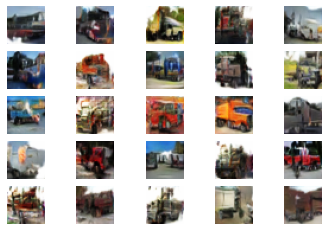

>286, 1/39, d1=0.142, d2=0.301 g=3.361
>286, 2/39, d1=0.293, d2=0.281 g=2.821
>286, 3/39, d1=0.336, d2=0.314 g=3.243
>286, 4/39, d1=0.333, d2=0.205 g=2.735
>286, 5/39, d1=0.166, d2=0.334 g=2.937
>286, 6/39, d1=0.333, d2=0.226 g=2.710
>286, 7/39, d1=0.300, d2=0.363 g=3.197
>286, 8/39, d1=0.212, d2=0.192 g=3.256
>286, 9/39, d1=0.340, d2=0.408 g=3.353
>286, 10/39, d1=0.242, d2=0.257 g=3.580
>286, 11/39, d1=0.291, d2=0.171 g=2.973
>286, 12/39, d1=0.348, d2=0.270 g=2.809
>286, 13/39, d1=0.182, d2=0.452 g=3.432
>286, 14/39, d1=0.259, d2=0.161 g=3.522
>286, 15/39, d1=0.393, d2=0.266 g=2.682
>286, 16/39, d1=0.190, d2=0.396 g=2.909
>286, 17/39, d1=0.382, d2=0.200 g=2.852
>286, 18/39, d1=0.292, d2=0.494 g=3.140
>286, 19/39, d1=0.229, d2=0.175 g=3.447
>286, 20/39, d1=0.474, d2=0.352 g=3.019
>286, 21/39, d1=0.208, d2=0.189 g=3.037
>286, 22/39, d1=0.462, d2=0.510 g=3.141
>286, 23/39, d1=0.349, d2=0.195 g=3.247
>286, 24/39, d1=0.329, d2=0.230 g=2.962
>286, 25/39, d1=0.254, d2=0.262 g=2.655
>286, 26/

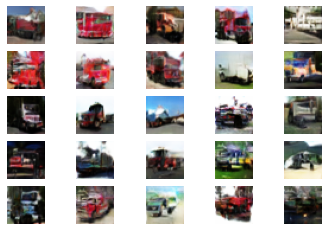

>291, 1/39, d1=0.141, d2=0.249 g=3.109
>291, 2/39, d1=0.255, d2=0.305 g=3.178
>291, 3/39, d1=0.192, d2=0.205 g=3.502
>291, 4/39, d1=0.281, d2=0.250 g=3.275
>291, 5/39, d1=0.237, d2=0.278 g=3.262
>291, 6/39, d1=0.283, d2=0.226 g=3.041
>291, 7/39, d1=0.315, d2=0.422 g=3.185
>291, 8/39, d1=0.323, d2=0.235 g=3.189
>291, 9/39, d1=0.250, d2=0.239 g=3.348
>291, 10/39, d1=0.369, d2=0.367 g=3.343
>291, 11/39, d1=0.226, d2=0.207 g=3.274
>291, 12/39, d1=0.363, d2=0.531 g=3.454
>291, 13/39, d1=0.342, d2=0.294 g=2.896
>291, 14/39, d1=0.290, d2=0.466 g=3.129
>291, 15/39, d1=0.275, d2=0.228 g=3.268
>291, 16/39, d1=0.428, d2=0.245 g=2.848
>291, 17/39, d1=0.254, d2=0.442 g=3.034
>291, 18/39, d1=0.472, d2=0.244 g=2.823
>291, 19/39, d1=0.262, d2=0.292 g=3.196
>291, 20/39, d1=0.366, d2=0.203 g=2.713
>291, 21/39, d1=0.223, d2=0.450 g=3.214
>291, 22/39, d1=0.377, d2=0.271 g=2.738
>291, 23/39, d1=0.437, d2=0.218 g=2.398
>291, 24/39, d1=0.172, d2=0.429 g=3.001
>291, 25/39, d1=0.419, d2=0.247 g=2.792
>291, 26/

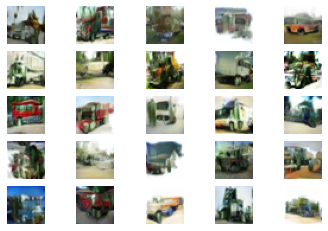

>296, 1/39, d1=0.173, d2=0.388 g=3.262
>296, 2/39, d1=0.203, d2=0.258 g=3.669
>296, 3/39, d1=0.215, d2=0.328 g=3.691
>296, 4/39, d1=0.262, d2=0.213 g=3.377
>296, 5/39, d1=0.272, d2=0.259 g=3.356
>296, 6/39, d1=0.215, d2=0.300 g=3.587
>296, 7/39, d1=0.293, d2=0.204 g=3.334
>296, 8/39, d1=0.279, d2=0.265 g=3.362
>296, 9/39, d1=0.178, d2=0.170 g=3.464
>296, 10/39, d1=0.270, d2=0.441 g=3.819
>296, 11/39, d1=0.310, d2=0.139 g=3.622
>296, 12/39, d1=0.375, d2=0.251 g=2.764
>296, 13/39, d1=0.209, d2=0.336 g=3.406
>296, 14/39, d1=0.275, d2=0.227 g=3.246
>296, 15/39, d1=0.263, d2=0.183 g=3.089
>296, 16/39, d1=0.207, d2=0.175 g=2.842
>296, 17/39, d1=0.170, d2=0.212 g=3.659
>296, 18/39, d1=0.439, d2=0.322 g=3.203
>296, 19/39, d1=0.262, d2=0.323 g=3.189
>296, 20/39, d1=0.350, d2=0.477 g=3.627
>296, 21/39, d1=0.313, d2=0.239 g=3.867
>296, 22/39, d1=0.486, d2=0.495 g=2.976
>296, 23/39, d1=0.308, d2=0.278 g=2.941
>296, 24/39, d1=0.255, d2=0.218 g=3.209
>296, 25/39, d1=0.299, d2=0.221 g=3.298
>296, 26/

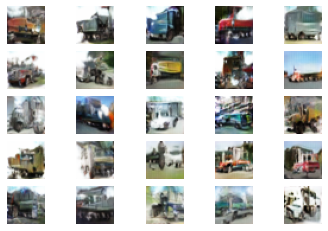

In [ ]:
# size of latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)